In [2]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [4]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= 2.0 # uni-var/ std
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= 2.0 # uni-var/ std
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [5]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3087, acc-0.0800, valid loss-2.3034, acc-0.0894, test loss-2.3037, acc-0.0935
Iter-20, train loss-2.3167, acc-0.0400, valid loss-2.3032, acc-0.0902, test loss-2.3035, acc-0.0941
Iter-30, train loss-2.3211, acc-0.1000, valid loss-2.3031, acc-0.0904, test loss-2.3034, acc-0.0945
Iter-40, train loss-2.3090, acc-0.0400, valid loss-2.3029, acc-0.0900, test loss-2.3032, acc-0.0951
Iter-50, train loss-2.2886, acc-0.1000, valid loss-2.3028, acc-0.0904, test loss-2.3031, acc-0.0958
Iter-60, train loss-2.2755, acc-0.1600, valid loss-2.3026, acc-0.0908, test loss-2.3029, acc-0.0960
Iter-70, train loss-2.3107, acc-0.0400, valid loss-2.3024, acc-0.0914, test loss-2.3028, acc-0.0965
Iter-80, train loss-2.3248, acc-0.0800, valid loss-2.3023, acc-0.0920, test loss-2.3026, acc-0.0969
Iter-90, train loss-2.2951, acc-0.1400, valid loss-2.3021, acc-0.0924, test loss-2.3025, acc-0.0971
Iter-100, train loss-2.3158, acc-0.1200, valid loss-2.3020, acc-0.0928, test loss-2.3023, acc-0.0973

Iter-830, train loss-2.2870, acc-0.1400, valid loss-2.2889, acc-0.1234, test loss-2.2898, acc-0.1255
Iter-840, train loss-2.2806, acc-0.1400, valid loss-2.2886, acc-0.1250, test loss-2.2895, acc-0.1259
Iter-850, train loss-2.3080, acc-0.0600, valid loss-2.2884, acc-0.1264, test loss-2.2893, acc-0.1264
Iter-860, train loss-2.2623, acc-0.1400, valid loss-2.2881, acc-0.1274, test loss-2.2890, acc-0.1275
Iter-870, train loss-2.2885, acc-0.1600, valid loss-2.2879, acc-0.1286, test loss-2.2888, acc-0.1278
Iter-880, train loss-2.3148, acc-0.0600, valid loss-2.2876, acc-0.1300, test loss-2.2885, acc-0.1285
Iter-890, train loss-2.3312, acc-0.0800, valid loss-2.2874, acc-0.1304, test loss-2.2883, acc-0.1289
Iter-900, train loss-2.3034, acc-0.1400, valid loss-2.2872, acc-0.1312, test loss-2.2881, acc-0.1293
Iter-910, train loss-2.2864, acc-0.1200, valid loss-2.2869, acc-0.1316, test loss-2.2879, acc-0.1297
Iter-920, train loss-2.2692, acc-0.1400, valid loss-2.2867, acc-0.1320, test loss-2.2877, a

Iter-1640, train loss-2.2542, acc-0.2600, valid loss-2.2632, acc-0.1826, test loss-2.2644, acc-0.1769
Iter-1650, train loss-2.2474, acc-0.2000, valid loss-2.2627, acc-0.1826, test loss-2.2639, acc-0.1772
Iter-1660, train loss-2.2462, acc-0.2000, valid loss-2.2622, acc-0.1838, test loss-2.2635, acc-0.1786
Iter-1670, train loss-2.2654, acc-0.2200, valid loss-2.2618, acc-0.1850, test loss-2.2631, acc-0.1794
Iter-1680, train loss-2.2792, acc-0.0600, valid loss-2.2614, acc-0.1864, test loss-2.2626, acc-0.1803
Iter-1690, train loss-2.2890, acc-0.1400, valid loss-2.2610, acc-0.1874, test loss-2.2622, acc-0.1808
Iter-1700, train loss-2.2561, acc-0.2800, valid loss-2.2605, acc-0.1886, test loss-2.2617, acc-0.1814
Iter-1710, train loss-2.2712, acc-0.1600, valid loss-2.2600, acc-0.1894, test loss-2.2613, acc-0.1824
Iter-1720, train loss-2.2627, acc-0.1600, valid loss-2.2596, acc-0.1898, test loss-2.2609, acc-0.1831
Iter-1730, train loss-2.2527, acc-0.1600, valid loss-2.2592, acc-0.1902, test loss

Iter-2450, train loss-2.2005, acc-0.3000, valid loss-2.2162, acc-0.2506, test loss-2.2174, acc-0.2459
Iter-2460, train loss-2.2170, acc-0.2800, valid loss-2.2155, acc-0.2516, test loss-2.2167, acc-0.2467
Iter-2470, train loss-2.2467, acc-0.1200, valid loss-2.2148, acc-0.2524, test loss-2.2160, acc-0.2472
Iter-2480, train loss-2.2278, acc-0.2200, valid loss-2.2140, acc-0.2532, test loss-2.2152, acc-0.2478
Iter-2490, train loss-2.2161, acc-0.2200, valid loss-2.2132, acc-0.2542, test loss-2.2144, acc-0.2489
Iter-2500, train loss-2.2081, acc-0.2600, valid loss-2.2124, acc-0.2544, test loss-2.2136, acc-0.2497
Iter-2510, train loss-2.1748, acc-0.3600, valid loss-2.2117, acc-0.2552, test loss-2.2128, acc-0.2500
Iter-2520, train loss-2.2354, acc-0.1800, valid loss-2.2109, acc-0.2562, test loss-2.2120, acc-0.2510
Iter-2530, train loss-2.1859, acc-0.3800, valid loss-2.2101, acc-0.2562, test loss-2.2113, acc-0.2515
Iter-2540, train loss-2.1945, acc-0.2400, valid loss-2.2093, acc-0.2570, test loss

Iter-3260, train loss-2.1368, acc-0.2800, valid loss-2.1453, acc-0.3086, test loss-2.1462, acc-0.3103
Iter-3270, train loss-2.1541, acc-0.3400, valid loss-2.1443, acc-0.3098, test loss-2.1452, acc-0.3117
Iter-3280, train loss-2.1275, acc-0.3600, valid loss-2.1433, acc-0.3110, test loss-2.1441, acc-0.3129
Iter-3290, train loss-2.1588, acc-0.1800, valid loss-2.1423, acc-0.3130, test loss-2.1431, acc-0.3139
Iter-3300, train loss-2.1198, acc-0.3200, valid loss-2.1414, acc-0.3132, test loss-2.1422, acc-0.3150
Iter-3310, train loss-2.1923, acc-0.2400, valid loss-2.1404, acc-0.3144, test loss-2.1412, acc-0.3158
Iter-3320, train loss-2.2380, acc-0.2000, valid loss-2.1394, acc-0.3150, test loss-2.1402, acc-0.3170
Iter-3330, train loss-2.1609, acc-0.2600, valid loss-2.1384, acc-0.3166, test loss-2.1392, acc-0.3180
Iter-3340, train loss-2.0983, acc-0.3600, valid loss-2.1374, acc-0.3172, test loss-2.1383, acc-0.3194
Iter-3350, train loss-2.1048, acc-0.3600, valid loss-2.1364, acc-0.3184, test loss

Iter-4070, train loss-2.0351, acc-0.4800, valid loss-2.0564, acc-0.3814, test loss-2.0569, acc-0.3880
Iter-4080, train loss-2.1190, acc-0.3200, valid loss-2.0552, acc-0.3816, test loss-2.0557, acc-0.3884
Iter-4090, train loss-2.0532, acc-0.3400, valid loss-2.0540, acc-0.3814, test loss-2.0545, acc-0.3882
Iter-4100, train loss-2.0818, acc-0.3600, valid loss-2.0528, acc-0.3824, test loss-2.0533, acc-0.3898
Iter-4110, train loss-2.0366, acc-0.4200, valid loss-2.0516, acc-0.3834, test loss-2.0521, acc-0.3901
Iter-4120, train loss-2.0911, acc-0.3400, valid loss-2.0505, acc-0.3832, test loss-2.0509, acc-0.3903
Iter-4130, train loss-2.0465, acc-0.3600, valid loss-2.0493, acc-0.3848, test loss-2.0497, acc-0.3921
Iter-4140, train loss-2.0225, acc-0.3600, valid loss-2.0481, acc-0.3852, test loss-2.0485, acc-0.3924
Iter-4150, train loss-2.0431, acc-0.3800, valid loss-2.0468, acc-0.3856, test loss-2.0473, acc-0.3926
Iter-4160, train loss-2.0044, acc-0.4400, valid loss-2.0457, acc-0.3862, test loss

Iter-4880, train loss-1.9674, acc-0.3600, valid loss-1.9575, acc-0.4118, test loss-1.9576, acc-0.4230
Iter-4890, train loss-1.9626, acc-0.3600, valid loss-1.9562, acc-0.4120, test loss-1.9562, acc-0.4229
Iter-4900, train loss-1.9353, acc-0.4600, valid loss-1.9548, acc-0.4120, test loss-1.9549, acc-0.4228
Iter-4910, train loss-1.9590, acc-0.4600, valid loss-1.9535, acc-0.4120, test loss-1.9536, acc-0.4238
Iter-4920, train loss-1.9642, acc-0.4200, valid loss-1.9522, acc-0.4132, test loss-1.9523, acc-0.4244
Iter-4930, train loss-1.9430, acc-0.4800, valid loss-1.9511, acc-0.4130, test loss-1.9511, acc-0.4242
Iter-4940, train loss-2.0134, acc-0.3000, valid loss-1.9498, acc-0.4132, test loss-1.9498, acc-0.4241
Iter-4950, train loss-2.0539, acc-0.2600, valid loss-1.9486, acc-0.4138, test loss-1.9487, acc-0.4243
Iter-4960, train loss-1.8335, acc-0.4800, valid loss-1.9473, acc-0.4146, test loss-1.9473, acc-0.4246
Iter-4970, train loss-1.9934, acc-0.3200, valid loss-1.9460, acc-0.4148, test loss

Iter-5690, train loss-1.8626, acc-0.5000, valid loss-1.8542, acc-0.4468, test loss-1.8537, acc-0.4486
Iter-5700, train loss-1.8950, acc-0.3800, valid loss-1.8530, acc-0.4468, test loss-1.8525, acc-0.4490
Iter-5710, train loss-1.8647, acc-0.4200, valid loss-1.8517, acc-0.4466, test loss-1.8512, acc-0.4494
Iter-5720, train loss-1.7402, acc-0.5200, valid loss-1.8505, acc-0.4464, test loss-1.8499, acc-0.4495
Iter-5730, train loss-1.8920, acc-0.5000, valid loss-1.8491, acc-0.4466, test loss-1.8486, acc-0.4501
Iter-5740, train loss-1.9451, acc-0.3000, valid loss-1.8480, acc-0.4468, test loss-1.8474, acc-0.4503
Iter-5750, train loss-1.8445, acc-0.4800, valid loss-1.8468, acc-0.4466, test loss-1.8462, acc-0.4505
Iter-5760, train loss-1.9211, acc-0.3400, valid loss-1.8456, acc-0.4470, test loss-1.8450, acc-0.4509
Iter-5770, train loss-1.8676, acc-0.5200, valid loss-1.8443, acc-0.4470, test loss-1.8438, acc-0.4513
Iter-5780, train loss-1.6691, acc-0.6200, valid loss-1.8430, acc-0.4474, test loss

Iter-6500, train loss-1.6973, acc-0.5600, valid loss-1.7507, acc-0.4732, test loss-1.7496, acc-0.4761
Iter-6510, train loss-1.8736, acc-0.4000, valid loss-1.7495, acc-0.4742, test loss-1.7484, acc-0.4762
Iter-6520, train loss-1.8376, acc-0.3400, valid loss-1.7482, acc-0.4742, test loss-1.7471, acc-0.4764
Iter-6530, train loss-1.7338, acc-0.5400, valid loss-1.7470, acc-0.4746, test loss-1.7458, acc-0.4768
Iter-6540, train loss-1.5938, acc-0.6200, valid loss-1.7457, acc-0.4750, test loss-1.7445, acc-0.4771
Iter-6550, train loss-1.7404, acc-0.4800, valid loss-1.7444, acc-0.4750, test loss-1.7433, acc-0.4772
Iter-6560, train loss-1.7732, acc-0.5000, valid loss-1.7432, acc-0.4752, test loss-1.7420, acc-0.4775
Iter-6570, train loss-1.6677, acc-0.5200, valid loss-1.7419, acc-0.4752, test loss-1.7408, acc-0.4775
Iter-6580, train loss-1.7445, acc-0.5400, valid loss-1.7406, acc-0.4758, test loss-1.7395, acc-0.4778
Iter-6590, train loss-1.6115, acc-0.5800, valid loss-1.7393, acc-0.4762, test loss

Iter-7310, train loss-1.6243, acc-0.4600, valid loss-1.6484, acc-0.5032, test loss-1.6466, acc-0.5076
Iter-7320, train loss-1.6647, acc-0.5600, valid loss-1.6471, acc-0.5034, test loss-1.6453, acc-0.5076
Iter-7330, train loss-1.6617, acc-0.5000, valid loss-1.6458, acc-0.5034, test loss-1.6440, acc-0.5087
Iter-7340, train loss-1.6907, acc-0.5000, valid loss-1.6446, acc-0.5038, test loss-1.6428, acc-0.5089
Iter-7350, train loss-1.7082, acc-0.4800, valid loss-1.6435, acc-0.5038, test loss-1.6416, acc-0.5091
Iter-7360, train loss-1.6345, acc-0.5400, valid loss-1.6422, acc-0.5046, test loss-1.6403, acc-0.5095
Iter-7370, train loss-1.6199, acc-0.5400, valid loss-1.6410, acc-0.5054, test loss-1.6390, acc-0.5106
Iter-7380, train loss-1.6240, acc-0.5200, valid loss-1.6397, acc-0.5058, test loss-1.6378, acc-0.5109
Iter-7390, train loss-1.4962, acc-0.6200, valid loss-1.6385, acc-0.5058, test loss-1.6366, acc-0.5113
Iter-7400, train loss-1.5206, acc-0.6000, valid loss-1.6373, acc-0.5058, test loss

Iter-8120, train loss-1.6825, acc-0.4000, valid loss-1.5496, acc-0.5442, test loss-1.5472, acc-0.5478
Iter-8130, train loss-1.5298, acc-0.5600, valid loss-1.5485, acc-0.5450, test loss-1.5459, acc-0.5486
Iter-8140, train loss-1.4855, acc-0.6000, valid loss-1.5473, acc-0.5452, test loss-1.5448, acc-0.5488
Iter-8150, train loss-1.6370, acc-0.3600, valid loss-1.5462, acc-0.5452, test loss-1.5436, acc-0.5491
Iter-8160, train loss-1.6334, acc-0.4800, valid loss-1.5450, acc-0.5456, test loss-1.5425, acc-0.5495
Iter-8170, train loss-1.4916, acc-0.5000, valid loss-1.5438, acc-0.5464, test loss-1.5412, acc-0.5505
Iter-8180, train loss-1.5454, acc-0.5600, valid loss-1.5426, acc-0.5480, test loss-1.5400, acc-0.5514
Iter-8190, train loss-1.6018, acc-0.5200, valid loss-1.5415, acc-0.5488, test loss-1.5389, acc-0.5520
Iter-8200, train loss-1.6867, acc-0.4200, valid loss-1.5404, acc-0.5492, test loss-1.5377, acc-0.5519
Iter-8210, train loss-1.7330, acc-0.3600, valid loss-1.5392, acc-0.5500, test loss

Iter-8930, train loss-1.5391, acc-0.4800, valid loss-1.4572, acc-0.5878, test loss-1.4541, acc-0.5863
Iter-8940, train loss-1.3577, acc-0.6400, valid loss-1.4561, acc-0.5886, test loss-1.4530, acc-0.5862
Iter-8950, train loss-1.3477, acc-0.6400, valid loss-1.4550, acc-0.5890, test loss-1.4519, acc-0.5873
Iter-8960, train loss-1.4633, acc-0.5200, valid loss-1.4539, acc-0.5896, test loss-1.4508, acc-0.5875
Iter-8970, train loss-1.4899, acc-0.5400, valid loss-1.4528, acc-0.5896, test loss-1.4497, acc-0.5878
Iter-8980, train loss-1.4737, acc-0.6600, valid loss-1.4517, acc-0.5896, test loss-1.4485, acc-0.5883
Iter-8990, train loss-1.3584, acc-0.6000, valid loss-1.4505, acc-0.5904, test loss-1.4473, acc-0.5889
Iter-9000, train loss-1.4973, acc-0.5800, valid loss-1.4494, acc-0.5918, test loss-1.4462, acc-0.5894
Iter-9010, train loss-1.3122, acc-0.6600, valid loss-1.4483, acc-0.5918, test loss-1.4451, acc-0.5900
Iter-9020, train loss-1.5333, acc-0.6000, valid loss-1.4472, acc-0.5918, test loss

Iter-9740, train loss-1.4151, acc-0.5600, valid loss-1.3729, acc-0.6254, test loss-1.3695, acc-0.6262
Iter-9750, train loss-1.4121, acc-0.6600, valid loss-1.3720, acc-0.6260, test loss-1.3685, acc-0.6266
Iter-9760, train loss-1.3076, acc-0.6400, valid loss-1.3710, acc-0.6268, test loss-1.3676, acc-0.6272
Iter-9770, train loss-1.4431, acc-0.5600, valid loss-1.3700, acc-0.6264, test loss-1.3666, acc-0.6276
Iter-9780, train loss-1.3828, acc-0.5600, valid loss-1.3690, acc-0.6268, test loss-1.3656, acc-0.6282
Iter-9790, train loss-1.4310, acc-0.5600, valid loss-1.3680, acc-0.6268, test loss-1.3646, acc-0.6285
Iter-9800, train loss-1.2968, acc-0.7000, valid loss-1.3670, acc-0.6276, test loss-1.3636, acc-0.6286
Iter-9810, train loss-1.1958, acc-0.7000, valid loss-1.3660, acc-0.6280, test loss-1.3626, acc-0.6291
Iter-9820, train loss-1.3550, acc-0.6400, valid loss-1.3650, acc-0.6292, test loss-1.3616, acc-0.6297
Iter-9830, train loss-1.4228, acc-0.5600, valid loss-1.3641, acc-0.6292, test loss

Iter-10540, train loss-1.1486, acc-0.7600, valid loss-1.2973, acc-0.6592, test loss-1.2939, acc-0.6607
Iter-10550, train loss-1.1927, acc-0.7200, valid loss-1.2964, acc-0.6598, test loss-1.2930, acc-0.6611
Iter-10560, train loss-1.2256, acc-0.7000, valid loss-1.2955, acc-0.6598, test loss-1.2921, acc-0.6615
Iter-10570, train loss-1.3535, acc-0.6200, valid loss-1.2946, acc-0.6600, test loss-1.2911, acc-0.6618
Iter-10580, train loss-1.4112, acc-0.6800, valid loss-1.2936, acc-0.6602, test loss-1.2902, acc-0.6624
Iter-10590, train loss-1.2759, acc-0.6400, valid loss-1.2928, acc-0.6604, test loss-1.2893, acc-0.6625
Iter-10600, train loss-1.2615, acc-0.7000, valid loss-1.2919, acc-0.6604, test loss-1.2885, acc-0.6629
Iter-10610, train loss-1.2293, acc-0.6600, valid loss-1.2910, acc-0.6608, test loss-1.2876, acc-0.6636
Iter-10620, train loss-1.4199, acc-0.5600, valid loss-1.2901, acc-0.6606, test loss-1.2867, acc-0.6637
Iter-10630, train loss-1.3337, acc-0.6800, valid loss-1.2892, acc-0.6606,

Iter-11340, train loss-1.2039, acc-0.7000, valid loss-1.2287, acc-0.6840, test loss-1.2257, acc-0.6900
Iter-11350, train loss-1.2052, acc-0.6800, valid loss-1.2279, acc-0.6842, test loss-1.2249, acc-0.6901
Iter-11360, train loss-1.2345, acc-0.6200, valid loss-1.2271, acc-0.6846, test loss-1.2241, acc-0.6906
Iter-11370, train loss-1.2446, acc-0.7000, valid loss-1.2263, acc-0.6848, test loss-1.2233, acc-0.6910
Iter-11380, train loss-1.1660, acc-0.7000, valid loss-1.2255, acc-0.6846, test loss-1.2225, acc-0.6917
Iter-11390, train loss-1.4222, acc-0.6000, valid loss-1.2247, acc-0.6848, test loss-1.2217, acc-0.6921
Iter-11400, train loss-1.2451, acc-0.6400, valid loss-1.2239, acc-0.6852, test loss-1.2209, acc-0.6924
Iter-11410, train loss-1.2739, acc-0.6400, valid loss-1.2231, acc-0.6854, test loss-1.2201, acc-0.6928
Iter-11420, train loss-1.3266, acc-0.6000, valid loss-1.2223, acc-0.6858, test loss-1.2192, acc-0.6928
Iter-11430, train loss-1.2370, acc-0.6400, valid loss-1.2215, acc-0.6860,

Iter-12140, train loss-1.0862, acc-0.7200, valid loss-1.1665, acc-0.7056, test loss-1.1639, acc-0.7135
Iter-12150, train loss-1.1775, acc-0.7200, valid loss-1.1657, acc-0.7058, test loss-1.1631, acc-0.7142
Iter-12160, train loss-1.1992, acc-0.6200, valid loss-1.1650, acc-0.7054, test loss-1.1623, acc-0.7139
Iter-12170, train loss-1.0745, acc-0.8400, valid loss-1.1643, acc-0.7060, test loss-1.1616, acc-0.7139
Iter-12180, train loss-1.3207, acc-0.5600, valid loss-1.1635, acc-0.7062, test loss-1.1609, acc-0.7143
Iter-12190, train loss-1.0330, acc-0.8000, valid loss-1.1628, acc-0.7064, test loss-1.1602, acc-0.7142
Iter-12200, train loss-1.0903, acc-0.7400, valid loss-1.1621, acc-0.7066, test loss-1.1595, acc-0.7144
Iter-12210, train loss-1.0573, acc-0.7400, valid loss-1.1614, acc-0.7066, test loss-1.1587, acc-0.7149
Iter-12220, train loss-1.2172, acc-0.7200, valid loss-1.1605, acc-0.7068, test loss-1.1580, acc-0.7151
Iter-12230, train loss-1.2937, acc-0.5000, valid loss-1.1599, acc-0.7066,

Iter-12940, train loss-1.1705, acc-0.7200, valid loss-1.1095, acc-0.7234, test loss-1.1073, acc-0.7270
Iter-12950, train loss-1.2272, acc-0.6400, valid loss-1.1088, acc-0.7236, test loss-1.1066, acc-0.7273
Iter-12960, train loss-1.3007, acc-0.6600, valid loss-1.1082, acc-0.7236, test loss-1.1060, acc-0.7276
Iter-12970, train loss-1.0632, acc-0.7000, valid loss-1.1075, acc-0.7236, test loss-1.1053, acc-0.7275
Iter-12980, train loss-1.1919, acc-0.6800, valid loss-1.1068, acc-0.7240, test loss-1.1046, acc-0.7272
Iter-12990, train loss-1.0421, acc-0.6800, valid loss-1.1062, acc-0.7248, test loss-1.1039, acc-0.7274
Iter-13000, train loss-1.1806, acc-0.7200, valid loss-1.1055, acc-0.7250, test loss-1.1033, acc-0.7274
Iter-13010, train loss-1.1559, acc-0.7200, valid loss-1.1049, acc-0.7252, test loss-1.1027, acc-0.7278
Iter-13020, train loss-1.1552, acc-0.7000, valid loss-1.1043, acc-0.7250, test loss-1.1021, acc-0.7278
Iter-13030, train loss-1.1023, acc-0.7800, valid loss-1.1036, acc-0.7254,

Iter-13740, train loss-0.9678, acc-0.7600, valid loss-1.0580, acc-0.7382, test loss-1.0562, acc-0.7409
Iter-13750, train loss-1.1445, acc-0.6600, valid loss-1.0574, acc-0.7384, test loss-1.0556, acc-0.7414
Iter-13760, train loss-1.2173, acc-0.6400, valid loss-1.0568, acc-0.7384, test loss-1.0550, acc-0.7417
Iter-13770, train loss-0.9840, acc-0.7800, valid loss-1.0562, acc-0.7382, test loss-1.0544, acc-0.7415
Iter-13780, train loss-1.1272, acc-0.7400, valid loss-1.0555, acc-0.7384, test loss-1.0538, acc-0.7414
Iter-13790, train loss-1.1550, acc-0.7000, valid loss-1.0549, acc-0.7388, test loss-1.0531, acc-0.7418
Iter-13800, train loss-1.2764, acc-0.5800, valid loss-1.0543, acc-0.7392, test loss-1.0525, acc-0.7419
Iter-13810, train loss-1.0879, acc-0.6600, valid loss-1.0537, acc-0.7390, test loss-1.0519, acc-0.7420
Iter-13820, train loss-0.9556, acc-0.7800, valid loss-1.0530, acc-0.7394, test loss-1.0513, acc-0.7421
Iter-13830, train loss-1.0901, acc-0.7000, valid loss-1.0524, acc-0.7394,

Iter-14540, train loss-1.0953, acc-0.7000, valid loss-1.0115, acc-0.7498, test loss-1.0102, acc-0.7527
Iter-14550, train loss-1.1074, acc-0.6600, valid loss-1.0109, acc-0.7502, test loss-1.0097, acc-0.7528
Iter-14560, train loss-0.7980, acc-0.9000, valid loss-1.0103, acc-0.7502, test loss-1.0091, acc-0.7528
Iter-14570, train loss-0.9687, acc-0.7400, valid loss-1.0097, acc-0.7504, test loss-1.0085, acc-0.7530
Iter-14580, train loss-1.0682, acc-0.7000, valid loss-1.0092, acc-0.7506, test loss-1.0079, acc-0.7533
Iter-14590, train loss-0.9354, acc-0.8200, valid loss-1.0086, acc-0.7510, test loss-1.0074, acc-0.7534
Iter-14600, train loss-1.0232, acc-0.7200, valid loss-1.0081, acc-0.7510, test loss-1.0068, acc-0.7535
Iter-14610, train loss-1.0025, acc-0.7200, valid loss-1.0075, acc-0.7510, test loss-1.0063, acc-0.7539
Iter-14620, train loss-1.0389, acc-0.7400, valid loss-1.0070, acc-0.7512, test loss-1.0058, acc-0.7541
Iter-14630, train loss-1.0682, acc-0.6800, valid loss-1.0065, acc-0.7514,

Iter-15340, train loss-0.8894, acc-0.8000, valid loss-0.9691, acc-0.7586, test loss-0.9681, acc-0.7636
Iter-15350, train loss-0.9678, acc-0.7600, valid loss-0.9685, acc-0.7586, test loss-0.9675, acc-0.7638
Iter-15360, train loss-0.9828, acc-0.7800, valid loss-0.9680, acc-0.7588, test loss-0.9670, acc-0.7638
Iter-15370, train loss-0.8814, acc-0.7600, valid loss-0.9675, acc-0.7590, test loss-0.9665, acc-0.7641
Iter-15380, train loss-1.1720, acc-0.6600, valid loss-0.9670, acc-0.7590, test loss-0.9660, acc-0.7643
Iter-15390, train loss-0.9684, acc-0.7600, valid loss-0.9666, acc-0.7590, test loss-0.9656, acc-0.7646
Iter-15400, train loss-0.9388, acc-0.8200, valid loss-0.9660, acc-0.7590, test loss-0.9651, acc-0.7645
Iter-15410, train loss-0.8169, acc-0.8600, valid loss-0.9655, acc-0.7590, test loss-0.9646, acc-0.7644
Iter-15420, train loss-0.9487, acc-0.7200, valid loss-0.9650, acc-0.7588, test loss-0.9641, acc-0.7646
Iter-15430, train loss-0.8449, acc-0.8200, valid loss-0.9645, acc-0.7590,

Iter-16140, train loss-0.9645, acc-0.7400, valid loss-0.9302, acc-0.7662, test loss-0.9296, acc-0.7720
Iter-16150, train loss-0.9927, acc-0.7200, valid loss-0.9297, acc-0.7668, test loss-0.9292, acc-0.7721
Iter-16160, train loss-0.8578, acc-0.8400, valid loss-0.9292, acc-0.7670, test loss-0.9287, acc-0.7721
Iter-16170, train loss-0.9029, acc-0.8200, valid loss-0.9287, acc-0.7678, test loss-0.9282, acc-0.7723
Iter-16180, train loss-0.9494, acc-0.8400, valid loss-0.9283, acc-0.7678, test loss-0.9278, acc-0.7724
Iter-16190, train loss-0.8236, acc-0.8200, valid loss-0.9278, acc-0.7680, test loss-0.9273, acc-0.7721
Iter-16200, train loss-0.8995, acc-0.7600, valid loss-0.9274, acc-0.7680, test loss-0.9269, acc-0.7724
Iter-16210, train loss-0.8115, acc-0.7600, valid loss-0.9269, acc-0.7686, test loss-0.9264, acc-0.7729
Iter-16220, train loss-0.9234, acc-0.7400, valid loss-0.9265, acc-0.7686, test loss-0.9260, acc-0.7729
Iter-16230, train loss-0.9301, acc-0.8400, valid loss-0.9260, acc-0.7686,

Iter-16940, train loss-0.8753, acc-0.7600, valid loss-0.8951, acc-0.7786, test loss-0.8949, acc-0.7793
Iter-16950, train loss-0.9289, acc-0.7200, valid loss-0.8947, acc-0.7786, test loss-0.8945, acc-0.7794
Iter-16960, train loss-0.8331, acc-0.8000, valid loss-0.8943, acc-0.7786, test loss-0.8941, acc-0.7793
Iter-16970, train loss-0.8231, acc-0.8000, valid loss-0.8938, acc-0.7788, test loss-0.8936, acc-0.7794
Iter-16980, train loss-0.7578, acc-0.8400, valid loss-0.8934, acc-0.7790, test loss-0.8933, acc-0.7796
Iter-16990, train loss-0.9986, acc-0.7600, valid loss-0.8930, acc-0.7788, test loss-0.8928, acc-0.7795
Iter-17000, train loss-0.8537, acc-0.7400, valid loss-0.8926, acc-0.7790, test loss-0.8924, acc-0.7795
Iter-17010, train loss-0.8792, acc-0.8000, valid loss-0.8922, acc-0.7790, test loss-0.8920, acc-0.7797
Iter-17020, train loss-0.8853, acc-0.6800, valid loss-0.8918, acc-0.7790, test loss-0.8916, acc-0.7795
Iter-17030, train loss-0.8645, acc-0.8600, valid loss-0.8914, acc-0.7784,

Iter-17740, train loss-0.7998, acc-0.8400, valid loss-0.8631, acc-0.7854, test loss-0.8633, acc-0.7863
Iter-17750, train loss-0.8680, acc-0.8000, valid loss-0.8627, acc-0.7854, test loss-0.8629, acc-0.7866
Iter-17760, train loss-0.8949, acc-0.7000, valid loss-0.8623, acc-0.7860, test loss-0.8625, acc-0.7871
Iter-17770, train loss-0.8127, acc-0.8400, valid loss-0.8619, acc-0.7862, test loss-0.8621, acc-0.7870
Iter-17780, train loss-0.8748, acc-0.8200, valid loss-0.8615, acc-0.7860, test loss-0.8617, acc-0.7872
Iter-17790, train loss-0.8378, acc-0.7600, valid loss-0.8611, acc-0.7860, test loss-0.8613, acc-0.7871
Iter-17800, train loss-0.8654, acc-0.7600, valid loss-0.8607, acc-0.7860, test loss-0.8610, acc-0.7875
Iter-17810, train loss-0.9437, acc-0.7400, valid loss-0.8604, acc-0.7862, test loss-0.8606, acc-0.7876
Iter-17820, train loss-0.9139, acc-0.8000, valid loss-0.8600, acc-0.7864, test loss-0.8603, acc-0.7874
Iter-17830, train loss-0.8975, acc-0.8000, valid loss-0.8596, acc-0.7864,

Iter-18540, train loss-0.8818, acc-0.7800, valid loss-0.8340, acc-0.7912, test loss-0.8346, acc-0.7933
Iter-18550, train loss-0.7633, acc-0.8800, valid loss-0.8336, acc-0.7912, test loss-0.8342, acc-0.7933
Iter-18560, train loss-0.8554, acc-0.7600, valid loss-0.8333, acc-0.7924, test loss-0.8339, acc-0.7931
Iter-18570, train loss-0.9690, acc-0.7000, valid loss-0.8330, acc-0.7928, test loss-0.8336, acc-0.7931
Iter-18580, train loss-0.8288, acc-0.8000, valid loss-0.8326, acc-0.7928, test loss-0.8333, acc-0.7936
Iter-18590, train loss-0.8469, acc-0.7600, valid loss-0.8323, acc-0.7926, test loss-0.8329, acc-0.7933
Iter-18600, train loss-0.8577, acc-0.7600, valid loss-0.8320, acc-0.7928, test loss-0.8326, acc-0.7936
Iter-18610, train loss-0.6933, acc-0.8600, valid loss-0.8316, acc-0.7928, test loss-0.8322, acc-0.7936
Iter-18620, train loss-0.8658, acc-0.7800, valid loss-0.8313, acc-0.7928, test loss-0.8319, acc-0.7940
Iter-18630, train loss-0.8004, acc-0.8200, valid loss-0.8309, acc-0.7932,

Iter-19340, train loss-0.8534, acc-0.8000, valid loss-0.8071, acc-0.7992, test loss-0.8080, acc-0.7997
Iter-19350, train loss-0.8961, acc-0.8000, valid loss-0.8068, acc-0.7992, test loss-0.8077, acc-0.7996
Iter-19360, train loss-0.9694, acc-0.7200, valid loss-0.8065, acc-0.7990, test loss-0.8074, acc-0.7998
Iter-19370, train loss-0.8938, acc-0.7600, valid loss-0.8062, acc-0.7992, test loss-0.8071, acc-0.7998
Iter-19380, train loss-0.6950, acc-0.8400, valid loss-0.8058, acc-0.7996, test loss-0.8068, acc-0.7998
Iter-19390, train loss-0.8781, acc-0.8000, valid loss-0.8055, acc-0.7996, test loss-0.8065, acc-0.7999
Iter-19400, train loss-0.7455, acc-0.8200, valid loss-0.8052, acc-0.7996, test loss-0.8061, acc-0.8001
Iter-19410, train loss-0.6249, acc-0.9200, valid loss-0.8049, acc-0.7996, test loss-0.8058, acc-0.8003
Iter-19420, train loss-0.6877, acc-0.8400, valid loss-0.8046, acc-0.7998, test loss-0.8055, acc-0.8003
Iter-19430, train loss-0.8199, acc-0.8400, valid loss-0.8042, acc-0.7996,

Iter-20140, train loss-1.0299, acc-0.7000, valid loss-0.7831, acc-0.8046, test loss-0.7842, acc-0.8032
Iter-20150, train loss-0.7316, acc-0.8200, valid loss-0.7828, acc-0.8044, test loss-0.7839, acc-0.8032
Iter-20160, train loss-0.7821, acc-0.7800, valid loss-0.7825, acc-0.8042, test loss-0.7836, acc-0.8034
Iter-20170, train loss-0.8678, acc-0.8000, valid loss-0.7822, acc-0.8044, test loss-0.7833, acc-0.8035
Iter-20180, train loss-0.7827, acc-0.8200, valid loss-0.7819, acc-0.8044, test loss-0.7830, acc-0.8035
Iter-20190, train loss-0.8462, acc-0.7800, valid loss-0.7816, acc-0.8046, test loss-0.7827, acc-0.8037
Iter-20200, train loss-0.7797, acc-0.8600, valid loss-0.7814, acc-0.8046, test loss-0.7825, acc-0.8037
Iter-20210, train loss-1.0220, acc-0.6400, valid loss-0.7811, acc-0.8048, test loss-0.7822, acc-0.8038
Iter-20220, train loss-0.8505, acc-0.7600, valid loss-0.7808, acc-0.8046, test loss-0.7819, acc-0.8040
Iter-20230, train loss-0.7486, acc-0.7400, valid loss-0.7805, acc-0.8046,

Iter-20940, train loss-0.7000, acc-0.8600, valid loss-0.7610, acc-0.8108, test loss-0.7625, acc-0.8087
Iter-20950, train loss-0.6707, acc-0.8400, valid loss-0.7608, acc-0.8106, test loss-0.7622, acc-0.8086
Iter-20960, train loss-0.7892, acc-0.7800, valid loss-0.7605, acc-0.8108, test loss-0.7620, acc-0.8088
Iter-20970, train loss-0.8391, acc-0.7400, valid loss-0.7602, acc-0.8108, test loss-0.7617, acc-0.8085
Iter-20980, train loss-0.7948, acc-0.8200, valid loss-0.7599, acc-0.8110, test loss-0.7614, acc-0.8087
Iter-20990, train loss-0.9254, acc-0.6800, valid loss-0.7597, acc-0.8110, test loss-0.7612, acc-0.8086
Iter-21000, train loss-0.9971, acc-0.8000, valid loss-0.7594, acc-0.8110, test loss-0.7609, acc-0.8086
Iter-21010, train loss-0.8821, acc-0.8200, valid loss-0.7592, acc-0.8114, test loss-0.7607, acc-0.8086
Iter-21020, train loss-0.7843, acc-0.8200, valid loss-0.7589, acc-0.8112, test loss-0.7604, acc-0.8088
Iter-21030, train loss-0.7903, acc-0.8600, valid loss-0.7587, acc-0.8114,

Iter-21740, train loss-0.8469, acc-0.7600, valid loss-0.7408, acc-0.8138, test loss-0.7426, acc-0.8134
Iter-21750, train loss-0.6563, acc-0.8600, valid loss-0.7405, acc-0.8138, test loss-0.7424, acc-0.8135
Iter-21760, train loss-0.5872, acc-0.9000, valid loss-0.7403, acc-0.8140, test loss-0.7421, acc-0.8137
Iter-21770, train loss-0.6371, acc-0.8600, valid loss-0.7400, acc-0.8138, test loss-0.7419, acc-0.8139
Iter-21780, train loss-0.7442, acc-0.8000, valid loss-0.7398, acc-0.8140, test loss-0.7416, acc-0.8138
Iter-21790, train loss-0.7261, acc-0.8200, valid loss-0.7396, acc-0.8142, test loss-0.7414, acc-0.8138
Iter-21800, train loss-0.8945, acc-0.6800, valid loss-0.7394, acc-0.8142, test loss-0.7412, acc-0.8141
Iter-21810, train loss-0.6854, acc-0.8200, valid loss-0.7391, acc-0.8142, test loss-0.7409, acc-0.8141
Iter-21820, train loss-0.9487, acc-0.6800, valid loss-0.7389, acc-0.8144, test loss-0.7407, acc-0.8141
Iter-21830, train loss-0.6437, acc-0.8600, valid loss-0.7387, acc-0.8144,

Iter-22540, train loss-0.8976, acc-0.7200, valid loss-0.7223, acc-0.8178, test loss-0.7244, acc-0.8181
Iter-22550, train loss-0.6774, acc-0.8200, valid loss-0.7221, acc-0.8178, test loss-0.7242, acc-0.8180
Iter-22560, train loss-0.6741, acc-0.8600, valid loss-0.7219, acc-0.8178, test loss-0.7239, acc-0.8181
Iter-22570, train loss-0.7536, acc-0.7800, valid loss-0.7217, acc-0.8180, test loss-0.7237, acc-0.8183
Iter-22580, train loss-0.6237, acc-0.8800, valid loss-0.7214, acc-0.8180, test loss-0.7235, acc-0.8182
Iter-22590, train loss-0.7263, acc-0.8400, valid loss-0.7212, acc-0.8182, test loss-0.7233, acc-0.8181
Iter-22600, train loss-0.8803, acc-0.7200, valid loss-0.7210, acc-0.8182, test loss-0.7231, acc-0.8183
Iter-22610, train loss-0.7997, acc-0.7800, valid loss-0.7208, acc-0.8182, test loss-0.7229, acc-0.8183
Iter-22620, train loss-0.5806, acc-0.9000, valid loss-0.7206, acc-0.8180, test loss-0.7226, acc-0.8182
Iter-22630, train loss-0.6514, acc-0.8800, valid loss-0.7204, acc-0.8180,

Iter-23340, train loss-0.7626, acc-0.7400, valid loss-0.7054, acc-0.8204, test loss-0.7076, acc-0.8225
Iter-23350, train loss-0.6978, acc-0.8200, valid loss-0.7052, acc-0.8206, test loss-0.7073, acc-0.8225
Iter-23360, train loss-0.7463, acc-0.7800, valid loss-0.7049, acc-0.8206, test loss-0.7071, acc-0.8225
Iter-23370, train loss-0.7666, acc-0.7800, valid loss-0.7047, acc-0.8208, test loss-0.7069, acc-0.8226
Iter-23380, train loss-0.7069, acc-0.7600, valid loss-0.7045, acc-0.8208, test loss-0.7067, acc-0.8227
Iter-23390, train loss-0.6092, acc-0.8800, valid loss-0.7043, acc-0.8208, test loss-0.7065, acc-0.8227
Iter-23400, train loss-0.7043, acc-0.8000, valid loss-0.7042, acc-0.8208, test loss-0.7063, acc-0.8229
Iter-23410, train loss-0.7891, acc-0.7800, valid loss-0.7039, acc-0.8208, test loss-0.7061, acc-0.8229
Iter-23420, train loss-0.6870, acc-0.8200, valid loss-0.7038, acc-0.8208, test loss-0.7059, acc-0.8228
Iter-23430, train loss-0.8217, acc-0.7600, valid loss-0.7036, acc-0.8206,

Iter-24140, train loss-0.6624, acc-0.8000, valid loss-0.6898, acc-0.8230, test loss-0.6920, acc-0.8257
Iter-24150, train loss-0.6828, acc-0.8400, valid loss-0.6896, acc-0.8230, test loss-0.6919, acc-0.8259
Iter-24160, train loss-0.8224, acc-0.7000, valid loss-0.6894, acc-0.8230, test loss-0.6917, acc-0.8258
Iter-24170, train loss-0.8080, acc-0.7400, valid loss-0.6892, acc-0.8230, test loss-0.6915, acc-0.8257
Iter-24180, train loss-0.5237, acc-0.9400, valid loss-0.6890, acc-0.8228, test loss-0.6913, acc-0.8258
Iter-24190, train loss-0.8206, acc-0.7600, valid loss-0.6888, acc-0.8230, test loss-0.6911, acc-0.8256
Iter-24200, train loss-0.5341, acc-0.8800, valid loss-0.6886, acc-0.8230, test loss-0.6909, acc-0.8258
Iter-24210, train loss-0.5958, acc-0.8200, valid loss-0.6884, acc-0.8230, test loss-0.6907, acc-0.8259
Iter-24220, train loss-0.5936, acc-0.9000, valid loss-0.6882, acc-0.8230, test loss-0.6905, acc-0.8259
Iter-24230, train loss-0.7949, acc-0.7800, valid loss-0.6880, acc-0.8230,

Iter-24940, train loss-0.6213, acc-0.8200, valid loss-0.6753, acc-0.8252, test loss-0.6776, acc-0.8287
Iter-24950, train loss-0.6184, acc-0.8600, valid loss-0.6751, acc-0.8252, test loss-0.6775, acc-0.8288
Iter-24960, train loss-0.7733, acc-0.8200, valid loss-0.6750, acc-0.8254, test loss-0.6773, acc-0.8292
Iter-24970, train loss-0.6406, acc-0.8800, valid loss-0.6748, acc-0.8256, test loss-0.6771, acc-0.8292
Iter-24980, train loss-0.5468, acc-0.9200, valid loss-0.6746, acc-0.8258, test loss-0.6770, acc-0.8294
Iter-24990, train loss-0.7086, acc-0.8600, valid loss-0.6744, acc-0.8260, test loss-0.6768, acc-0.8294
Iter-25000, train loss-0.6656, acc-0.8200, valid loss-0.6743, acc-0.8260, test loss-0.6766, acc-0.8296
Iter-25010, train loss-0.5277, acc-0.9000, valid loss-0.6741, acc-0.8258, test loss-0.6765, acc-0.8295
Iter-25020, train loss-0.7656, acc-0.7400, valid loss-0.6739, acc-0.8262, test loss-0.6763, acc-0.8295
Iter-25030, train loss-0.7891, acc-0.7800, valid loss-0.6738, acc-0.8258,

Iter-25740, train loss-0.6109, acc-0.8400, valid loss-0.6617, acc-0.8296, test loss-0.6642, acc-0.8307
Iter-25750, train loss-0.7306, acc-0.8200, valid loss-0.6616, acc-0.8294, test loss-0.6641, acc-0.8310
Iter-25760, train loss-0.6840, acc-0.8000, valid loss-0.6614, acc-0.8296, test loss-0.6639, acc-0.8309
Iter-25770, train loss-0.7803, acc-0.7600, valid loss-0.6612, acc-0.8296, test loss-0.6637, acc-0.8309
Iter-25780, train loss-0.4920, acc-0.8600, valid loss-0.6611, acc-0.8298, test loss-0.6636, acc-0.8309
Iter-25790, train loss-0.7467, acc-0.8400, valid loss-0.6609, acc-0.8298, test loss-0.6634, acc-0.8309
Iter-25800, train loss-0.7694, acc-0.7800, valid loss-0.6607, acc-0.8296, test loss-0.6632, acc-0.8309
Iter-25810, train loss-0.7159, acc-0.7600, valid loss-0.6606, acc-0.8296, test loss-0.6631, acc-0.8309
Iter-25820, train loss-0.6117, acc-0.9400, valid loss-0.6604, acc-0.8298, test loss-0.6629, acc-0.8310
Iter-25830, train loss-0.6651, acc-0.8000, valid loss-0.6602, acc-0.8298,

Iter-26540, train loss-0.6856, acc-0.8200, valid loss-0.6490, acc-0.8324, test loss-0.6518, acc-0.8326
Iter-26550, train loss-0.5734, acc-0.8600, valid loss-0.6489, acc-0.8328, test loss-0.6516, acc-0.8327
Iter-26560, train loss-0.7058, acc-0.8600, valid loss-0.6487, acc-0.8328, test loss-0.6514, acc-0.8328
Iter-26570, train loss-0.7576, acc-0.7600, valid loss-0.6486, acc-0.8326, test loss-0.6513, acc-0.8327
Iter-26580, train loss-0.6515, acc-0.7200, valid loss-0.6484, acc-0.8326, test loss-0.6511, acc-0.8328
Iter-26590, train loss-0.6361, acc-0.9200, valid loss-0.6483, acc-0.8324, test loss-0.6510, acc-0.8329
Iter-26600, train loss-0.6825, acc-0.7800, valid loss-0.6481, acc-0.8324, test loss-0.6508, acc-0.8328
Iter-26610, train loss-0.7214, acc-0.8400, valid loss-0.6480, acc-0.8324, test loss-0.6507, acc-0.8328
Iter-26620, train loss-0.8133, acc-0.7600, valid loss-0.6478, acc-0.8324, test loss-0.6505, acc-0.8328
Iter-26630, train loss-0.6609, acc-0.8200, valid loss-0.6476, acc-0.8326,

Iter-27340, train loss-0.7764, acc-0.8200, valid loss-0.6370, acc-0.8346, test loss-0.6399, acc-0.8352
Iter-27350, train loss-0.5610, acc-0.8200, valid loss-0.6369, acc-0.8344, test loss-0.6398, acc-0.8353
Iter-27360, train loss-0.5117, acc-0.8600, valid loss-0.6367, acc-0.8344, test loss-0.6396, acc-0.8353
Iter-27370, train loss-0.5164, acc-0.9600, valid loss-0.6366, acc-0.8344, test loss-0.6395, acc-0.8352
Iter-27380, train loss-0.7009, acc-0.8200, valid loss-0.6364, acc-0.8344, test loss-0.6394, acc-0.8354
Iter-27390, train loss-0.6985, acc-0.7800, valid loss-0.6363, acc-0.8344, test loss-0.6392, acc-0.8352
Iter-27400, train loss-0.6744, acc-0.8400, valid loss-0.6361, acc-0.8344, test loss-0.6391, acc-0.8352
Iter-27410, train loss-0.6536, acc-0.8400, valid loss-0.6360, acc-0.8344, test loss-0.6390, acc-0.8353
Iter-27420, train loss-0.4927, acc-0.9400, valid loss-0.6358, acc-0.8344, test loss-0.6388, acc-0.8353
Iter-27430, train loss-0.6729, acc-0.8600, valid loss-0.6357, acc-0.8344,

Iter-28140, train loss-0.4796, acc-0.9000, valid loss-0.6261, acc-0.8376, test loss-0.6291, acc-0.8356
Iter-28150, train loss-0.6213, acc-0.8400, valid loss-0.6259, acc-0.8376, test loss-0.6289, acc-0.8357
Iter-28160, train loss-0.6534, acc-0.8600, valid loss-0.6258, acc-0.8384, test loss-0.6288, acc-0.8356
Iter-28170, train loss-0.6505, acc-0.8200, valid loss-0.6257, acc-0.8376, test loss-0.6287, acc-0.8356
Iter-28180, train loss-0.6059, acc-0.7800, valid loss-0.6255, acc-0.8374, test loss-0.6285, acc-0.8357
Iter-28190, train loss-0.5240, acc-0.8400, valid loss-0.6254, acc-0.8376, test loss-0.6284, acc-0.8358
Iter-28200, train loss-0.6341, acc-0.8600, valid loss-0.6252, acc-0.8374, test loss-0.6282, acc-0.8359
Iter-28210, train loss-0.5884, acc-0.8600, valid loss-0.6251, acc-0.8378, test loss-0.6281, acc-0.8358
Iter-28220, train loss-0.5201, acc-0.8400, valid loss-0.6250, acc-0.8378, test loss-0.6280, acc-0.8357
Iter-28230, train loss-0.5185, acc-0.8600, valid loss-0.6249, acc-0.8378,

Iter-28940, train loss-0.5896, acc-0.7800, valid loss-0.6156, acc-0.8396, test loss-0.6187, acc-0.8379
Iter-28950, train loss-0.5748, acc-0.8400, valid loss-0.6155, acc-0.8400, test loss-0.6186, acc-0.8379
Iter-28960, train loss-0.5250, acc-0.8800, valid loss-0.6154, acc-0.8398, test loss-0.6185, acc-0.8379
Iter-28970, train loss-0.5734, acc-0.8600, valid loss-0.6152, acc-0.8398, test loss-0.6183, acc-0.8379
Iter-28980, train loss-0.7198, acc-0.8000, valid loss-0.6151, acc-0.8398, test loss-0.6182, acc-0.8380
Iter-28990, train loss-0.6508, acc-0.8200, valid loss-0.6150, acc-0.8400, test loss-0.6181, acc-0.8380
Iter-29000, train loss-0.6203, acc-0.8200, valid loss-0.6148, acc-0.8400, test loss-0.6179, acc-0.8380
Iter-29010, train loss-0.6789, acc-0.8000, valid loss-0.6147, acc-0.8400, test loss-0.6178, acc-0.8380
Iter-29020, train loss-0.9467, acc-0.7600, valid loss-0.6146, acc-0.8404, test loss-0.6177, acc-0.8380
Iter-29030, train loss-0.5501, acc-0.8800, valid loss-0.6145, acc-0.8406,

Iter-29740, train loss-0.6182, acc-0.8600, valid loss-0.6058, acc-0.8410, test loss-0.6088, acc-0.8397
Iter-29750, train loss-0.5779, acc-0.8400, valid loss-0.6057, acc-0.8412, test loss-0.6087, acc-0.8397
Iter-29760, train loss-0.6330, acc-0.8400, valid loss-0.6055, acc-0.8412, test loss-0.6086, acc-0.8397
Iter-29770, train loss-0.7105, acc-0.7600, valid loss-0.6054, acc-0.8414, test loss-0.6084, acc-0.8398
Iter-29780, train loss-0.6688, acc-0.8000, valid loss-0.6053, acc-0.8412, test loss-0.6083, acc-0.8399
Iter-29790, train loss-0.6832, acc-0.8400, valid loss-0.6052, acc-0.8412, test loss-0.6082, acc-0.8399
Iter-29800, train loss-0.8303, acc-0.7400, valid loss-0.6051, acc-0.8412, test loss-0.6081, acc-0.8399
Iter-29810, train loss-0.6073, acc-0.7800, valid loss-0.6050, acc-0.8414, test loss-0.6080, acc-0.8398
Iter-29820, train loss-0.5417, acc-0.7800, valid loss-0.6048, acc-0.8414, test loss-0.6079, acc-0.8399
Iter-29830, train loss-0.4040, acc-0.9800, valid loss-0.6047, acc-0.8414,

Iter-30540, train loss-0.5604, acc-0.8600, valid loss-0.5964, acc-0.8434, test loss-0.5994, acc-0.8414
Iter-30550, train loss-0.5052, acc-0.8600, valid loss-0.5963, acc-0.8434, test loss-0.5992, acc-0.8417
Iter-30560, train loss-0.6054, acc-0.8600, valid loss-0.5962, acc-0.8434, test loss-0.5991, acc-0.8415
Iter-30570, train loss-0.8094, acc-0.8000, valid loss-0.5961, acc-0.8434, test loss-0.5990, acc-0.8416
Iter-30580, train loss-0.6881, acc-0.7800, valid loss-0.5960, acc-0.8434, test loss-0.5989, acc-0.8418
Iter-30590, train loss-0.3766, acc-0.9400, valid loss-0.5959, acc-0.8434, test loss-0.5988, acc-0.8418
Iter-30600, train loss-0.5092, acc-0.8200, valid loss-0.5958, acc-0.8438, test loss-0.5987, acc-0.8418
Iter-30610, train loss-0.6977, acc-0.7600, valid loss-0.5957, acc-0.8436, test loss-0.5986, acc-0.8421
Iter-30620, train loss-0.5935, acc-0.8000, valid loss-0.5956, acc-0.8436, test loss-0.5985, acc-0.8419
Iter-30630, train loss-0.4923, acc-0.9000, valid loss-0.5955, acc-0.8436,

Iter-31340, train loss-0.7048, acc-0.8000, valid loss-0.5876, acc-0.8458, test loss-0.5905, acc-0.8434
Iter-31350, train loss-0.9613, acc-0.6800, valid loss-0.5875, acc-0.8456, test loss-0.5904, acc-0.8434
Iter-31360, train loss-0.6612, acc-0.8200, valid loss-0.5874, acc-0.8456, test loss-0.5903, acc-0.8434
Iter-31370, train loss-0.6243, acc-0.8600, valid loss-0.5873, acc-0.8458, test loss-0.5902, acc-0.8434
Iter-31380, train loss-0.4638, acc-0.9400, valid loss-0.5872, acc-0.8458, test loss-0.5901, acc-0.8436
Iter-31390, train loss-0.6560, acc-0.9000, valid loss-0.5870, acc-0.8456, test loss-0.5900, acc-0.8437
Iter-31400, train loss-0.4056, acc-0.9200, valid loss-0.5869, acc-0.8456, test loss-0.5899, acc-0.8437
Iter-31410, train loss-0.6755, acc-0.7400, valid loss-0.5868, acc-0.8458, test loss-0.5898, acc-0.8438
Iter-31420, train loss-0.5505, acc-0.8400, valid loss-0.5867, acc-0.8458, test loss-0.5896, acc-0.8438
Iter-31430, train loss-0.5202, acc-0.8800, valid loss-0.5866, acc-0.8460,

Iter-32140, train loss-0.8505, acc-0.7800, valid loss-0.5790, acc-0.8480, test loss-0.5821, acc-0.8453
Iter-32150, train loss-0.6128, acc-0.8400, valid loss-0.5789, acc-0.8484, test loss-0.5820, acc-0.8454
Iter-32160, train loss-0.5473, acc-0.8400, valid loss-0.5789, acc-0.8484, test loss-0.5819, acc-0.8452
Iter-32170, train loss-0.5301, acc-0.8800, valid loss-0.5788, acc-0.8482, test loss-0.5818, acc-0.8454
Iter-32180, train loss-0.5698, acc-0.8200, valid loss-0.5786, acc-0.8482, test loss-0.5817, acc-0.8456
Iter-32190, train loss-0.5344, acc-0.8800, valid loss-0.5785, acc-0.8486, test loss-0.5816, acc-0.8455
Iter-32200, train loss-0.6222, acc-0.8000, valid loss-0.5784, acc-0.8486, test loss-0.5815, acc-0.8456
Iter-32210, train loss-0.6747, acc-0.8000, valid loss-0.5783, acc-0.8486, test loss-0.5814, acc-0.8457
Iter-32220, train loss-0.5790, acc-0.8400, valid loss-0.5782, acc-0.8484, test loss-0.5813, acc-0.8457
Iter-32230, train loss-0.5583, acc-0.8400, valid loss-0.5781, acc-0.8486,

Iter-32940, train loss-0.5782, acc-0.8200, valid loss-0.5711, acc-0.8500, test loss-0.5742, acc-0.8470
Iter-32950, train loss-0.5868, acc-0.7800, valid loss-0.5710, acc-0.8500, test loss-0.5741, acc-0.8471
Iter-32960, train loss-0.4474, acc-0.8800, valid loss-0.5709, acc-0.8500, test loss-0.5740, acc-0.8471
Iter-32970, train loss-0.7019, acc-0.7600, valid loss-0.5708, acc-0.8500, test loss-0.5739, acc-0.8470
Iter-32980, train loss-0.4754, acc-0.8800, valid loss-0.5707, acc-0.8500, test loss-0.5738, acc-0.8472
Iter-32990, train loss-0.5877, acc-0.8200, valid loss-0.5706, acc-0.8500, test loss-0.5737, acc-0.8473
Iter-33000, train loss-0.7974, acc-0.7600, valid loss-0.5705, acc-0.8500, test loss-0.5737, acc-0.8473
Iter-33010, train loss-0.5235, acc-0.8400, valid loss-0.5704, acc-0.8500, test loss-0.5735, acc-0.8473
Iter-33020, train loss-0.3787, acc-0.9200, valid loss-0.5703, acc-0.8502, test loss-0.5735, acc-0.8474
Iter-33030, train loss-0.6145, acc-0.8600, valid loss-0.5702, acc-0.8502,

Iter-33740, train loss-0.4381, acc-0.9000, valid loss-0.5635, acc-0.8516, test loss-0.5666, acc-0.8486
Iter-33750, train loss-0.7670, acc-0.8400, valid loss-0.5635, acc-0.8516, test loss-0.5665, acc-0.8486
Iter-33760, train loss-0.6147, acc-0.8600, valid loss-0.5634, acc-0.8516, test loss-0.5664, acc-0.8486
Iter-33770, train loss-0.6321, acc-0.7800, valid loss-0.5633, acc-0.8516, test loss-0.5663, acc-0.8486
Iter-33780, train loss-0.5017, acc-0.8800, valid loss-0.5632, acc-0.8516, test loss-0.5663, acc-0.8486
Iter-33790, train loss-0.4382, acc-0.8800, valid loss-0.5631, acc-0.8516, test loss-0.5662, acc-0.8487
Iter-33800, train loss-0.6364, acc-0.8600, valid loss-0.5630, acc-0.8516, test loss-0.5661, acc-0.8486
Iter-33810, train loss-0.4701, acc-0.8600, valid loss-0.5629, acc-0.8516, test loss-0.5660, acc-0.8487
Iter-33820, train loss-0.6600, acc-0.8200, valid loss-0.5628, acc-0.8516, test loss-0.5659, acc-0.8485
Iter-33830, train loss-0.5404, acc-0.8400, valid loss-0.5628, acc-0.8516,

Iter-34540, train loss-0.6113, acc-0.7600, valid loss-0.5563, acc-0.8522, test loss-0.5594, acc-0.8503
Iter-34550, train loss-0.6839, acc-0.8200, valid loss-0.5562, acc-0.8522, test loss-0.5593, acc-0.8502
Iter-34560, train loss-0.6024, acc-0.8600, valid loss-0.5561, acc-0.8524, test loss-0.5592, acc-0.8503
Iter-34570, train loss-0.7617, acc-0.7000, valid loss-0.5560, acc-0.8524, test loss-0.5591, acc-0.8504
Iter-34580, train loss-0.8138, acc-0.7400, valid loss-0.5559, acc-0.8526, test loss-0.5590, acc-0.8504
Iter-34590, train loss-0.6990, acc-0.7600, valid loss-0.5558, acc-0.8522, test loss-0.5589, acc-0.8504
Iter-34600, train loss-0.5418, acc-0.8400, valid loss-0.5557, acc-0.8524, test loss-0.5588, acc-0.8503
Iter-34610, train loss-0.5764, acc-0.8200, valid loss-0.5556, acc-0.8524, test loss-0.5587, acc-0.8503
Iter-34620, train loss-0.3812, acc-0.9400, valid loss-0.5555, acc-0.8524, test loss-0.5587, acc-0.8500
Iter-34630, train loss-0.9024, acc-0.7600, valid loss-0.5554, acc-0.8524,

Iter-35340, train loss-0.6155, acc-0.8400, valid loss-0.5492, acc-0.8528, test loss-0.5525, acc-0.8513
Iter-35350, train loss-0.5649, acc-0.8800, valid loss-0.5492, acc-0.8528, test loss-0.5524, acc-0.8513
Iter-35360, train loss-0.5584, acc-0.8600, valid loss-0.5491, acc-0.8528, test loss-0.5523, acc-0.8514
Iter-35370, train loss-0.7508, acc-0.8000, valid loss-0.5490, acc-0.8530, test loss-0.5523, acc-0.8512
Iter-35380, train loss-0.4530, acc-0.9200, valid loss-0.5489, acc-0.8530, test loss-0.5522, acc-0.8514
Iter-35390, train loss-0.6712, acc-0.7800, valid loss-0.5488, acc-0.8528, test loss-0.5521, acc-0.8515
Iter-35400, train loss-0.5854, acc-0.8600, valid loss-0.5487, acc-0.8532, test loss-0.5520, acc-0.8514
Iter-35410, train loss-0.5620, acc-0.8800, valid loss-0.5487, acc-0.8532, test loss-0.5519, acc-0.8515
Iter-35420, train loss-0.6490, acc-0.8000, valid loss-0.5486, acc-0.8530, test loss-0.5518, acc-0.8516
Iter-35430, train loss-0.6340, acc-0.7800, valid loss-0.5485, acc-0.8534,

Iter-36140, train loss-0.6141, acc-0.7600, valid loss-0.5427, acc-0.8554, test loss-0.5460, acc-0.8525
Iter-36150, train loss-0.6217, acc-0.7800, valid loss-0.5426, acc-0.8554, test loss-0.5459, acc-0.8526
Iter-36160, train loss-0.8417, acc-0.8000, valid loss-0.5425, acc-0.8554, test loss-0.5458, acc-0.8526
Iter-36170, train loss-0.6548, acc-0.8000, valid loss-0.5425, acc-0.8554, test loss-0.5457, acc-0.8527
Iter-36180, train loss-0.6178, acc-0.8400, valid loss-0.5424, acc-0.8554, test loss-0.5457, acc-0.8527
Iter-36190, train loss-0.4876, acc-0.9200, valid loss-0.5423, acc-0.8554, test loss-0.5456, acc-0.8527
Iter-36200, train loss-0.5884, acc-0.8600, valid loss-0.5422, acc-0.8554, test loss-0.5455, acc-0.8527
Iter-36210, train loss-0.4602, acc-0.8600, valid loss-0.5421, acc-0.8552, test loss-0.5454, acc-0.8527
Iter-36220, train loss-0.6307, acc-0.8200, valid loss-0.5420, acc-0.8552, test loss-0.5453, acc-0.8525
Iter-36230, train loss-0.5493, acc-0.8200, valid loss-0.5420, acc-0.8550,

Iter-36940, train loss-0.5211, acc-0.8000, valid loss-0.5363, acc-0.8560, test loss-0.5396, acc-0.8539
Iter-36950, train loss-0.4803, acc-0.9000, valid loss-0.5363, acc-0.8560, test loss-0.5396, acc-0.8540
Iter-36960, train loss-0.9109, acc-0.8000, valid loss-0.5362, acc-0.8558, test loss-0.5395, acc-0.8540
Iter-36970, train loss-0.6656, acc-0.8400, valid loss-0.5361, acc-0.8560, test loss-0.5394, acc-0.8542
Iter-36980, train loss-0.4951, acc-0.8800, valid loss-0.5361, acc-0.8562, test loss-0.5393, acc-0.8541
Iter-36990, train loss-0.4956, acc-0.8600, valid loss-0.5360, acc-0.8560, test loss-0.5392, acc-0.8542
Iter-37000, train loss-0.5368, acc-0.8400, valid loss-0.5359, acc-0.8560, test loss-0.5392, acc-0.8542
Iter-37010, train loss-0.4608, acc-0.9000, valid loss-0.5358, acc-0.8560, test loss-0.5391, acc-0.8542
Iter-37020, train loss-0.7271, acc-0.8000, valid loss-0.5357, acc-0.8560, test loss-0.5390, acc-0.8542
Iter-37030, train loss-0.5327, acc-0.8600, valid loss-0.5357, acc-0.8560,

Iter-37740, train loss-0.4674, acc-0.8600, valid loss-0.5302, acc-0.8566, test loss-0.5335, acc-0.8552
Iter-37750, train loss-0.6082, acc-0.8200, valid loss-0.5301, acc-0.8566, test loss-0.5334, acc-0.8552
Iter-37760, train loss-0.5686, acc-0.8200, valid loss-0.5300, acc-0.8566, test loss-0.5333, acc-0.8551
Iter-37770, train loss-0.5740, acc-0.8400, valid loss-0.5299, acc-0.8568, test loss-0.5332, acc-0.8552
Iter-37780, train loss-0.3651, acc-0.9200, valid loss-0.5298, acc-0.8568, test loss-0.5332, acc-0.8552
Iter-37790, train loss-0.5986, acc-0.8000, valid loss-0.5298, acc-0.8568, test loss-0.5331, acc-0.8552
Iter-37800, train loss-0.4717, acc-0.9200, valid loss-0.5297, acc-0.8568, test loss-0.5330, acc-0.8552
Iter-37810, train loss-0.7175, acc-0.7600, valid loss-0.5296, acc-0.8570, test loss-0.5330, acc-0.8553
Iter-37820, train loss-0.5366, acc-0.9000, valid loss-0.5296, acc-0.8570, test loss-0.5329, acc-0.8552
Iter-37830, train loss-0.3822, acc-0.9400, valid loss-0.5295, acc-0.8570,

Iter-38540, train loss-0.4897, acc-0.8400, valid loss-0.5241, acc-0.8586, test loss-0.5276, acc-0.8559
Iter-38550, train loss-0.5616, acc-0.8600, valid loss-0.5241, acc-0.8586, test loss-0.5275, acc-0.8561
Iter-38560, train loss-0.6654, acc-0.7600, valid loss-0.5240, acc-0.8586, test loss-0.5274, acc-0.8561
Iter-38570, train loss-0.4933, acc-0.8400, valid loss-0.5239, acc-0.8586, test loss-0.5274, acc-0.8561
Iter-38580, train loss-0.4615, acc-0.8800, valid loss-0.5239, acc-0.8586, test loss-0.5273, acc-0.8563
Iter-38590, train loss-0.6427, acc-0.8200, valid loss-0.5238, acc-0.8586, test loss-0.5272, acc-0.8563
Iter-38600, train loss-0.5446, acc-0.8200, valid loss-0.5238, acc-0.8586, test loss-0.5272, acc-0.8564
Iter-38610, train loss-0.5636, acc-0.8200, valid loss-0.5237, acc-0.8588, test loss-0.5271, acc-0.8565
Iter-38620, train loss-0.6140, acc-0.8600, valid loss-0.5236, acc-0.8586, test loss-0.5270, acc-0.8564
Iter-38630, train loss-0.5729, acc-0.8600, valid loss-0.5236, acc-0.8586,

Iter-39340, train loss-0.4441, acc-0.9200, valid loss-0.5185, acc-0.8602, test loss-0.5219, acc-0.8569
Iter-39350, train loss-0.5735, acc-0.8400, valid loss-0.5184, acc-0.8604, test loss-0.5218, acc-0.8569
Iter-39360, train loss-0.5036, acc-0.8400, valid loss-0.5183, acc-0.8604, test loss-0.5217, acc-0.8570
Iter-39370, train loss-0.6576, acc-0.8000, valid loss-0.5182, acc-0.8602, test loss-0.5217, acc-0.8570
Iter-39380, train loss-0.6680, acc-0.8400, valid loss-0.5182, acc-0.8602, test loss-0.5216, acc-0.8571
Iter-39390, train loss-0.7990, acc-0.8000, valid loss-0.5181, acc-0.8600, test loss-0.5215, acc-0.8571
Iter-39400, train loss-0.4575, acc-0.8600, valid loss-0.5181, acc-0.8602, test loss-0.5215, acc-0.8571
Iter-39410, train loss-0.3358, acc-0.9400, valid loss-0.5180, acc-0.8600, test loss-0.5214, acc-0.8571
Iter-39420, train loss-0.6139, acc-0.8600, valid loss-0.5179, acc-0.8602, test loss-0.5213, acc-0.8572
Iter-39430, train loss-0.4202, acc-0.9000, valid loss-0.5179, acc-0.8600,

Iter-40140, train loss-0.4207, acc-0.8800, valid loss-0.5131, acc-0.8608, test loss-0.5164, acc-0.8592
Iter-40150, train loss-0.5558, acc-0.8200, valid loss-0.5131, acc-0.8610, test loss-0.5163, acc-0.8592
Iter-40160, train loss-0.6488, acc-0.7400, valid loss-0.5130, acc-0.8610, test loss-0.5162, acc-0.8592
Iter-40170, train loss-0.5562, acc-0.8400, valid loss-0.5129, acc-0.8610, test loss-0.5162, acc-0.8593
Iter-40180, train loss-0.6126, acc-0.8800, valid loss-0.5129, acc-0.8610, test loss-0.5161, acc-0.8592
Iter-40190, train loss-0.6976, acc-0.8400, valid loss-0.5128, acc-0.8610, test loss-0.5161, acc-0.8592
Iter-40200, train loss-0.7311, acc-0.7600, valid loss-0.5128, acc-0.8610, test loss-0.5160, acc-0.8592
Iter-40210, train loss-0.5108, acc-0.8600, valid loss-0.5127, acc-0.8610, test loss-0.5159, acc-0.8593
Iter-40220, train loss-0.4498, acc-0.8600, valid loss-0.5126, acc-0.8610, test loss-0.5159, acc-0.8592
Iter-40230, train loss-0.4098, acc-0.8800, valid loss-0.5125, acc-0.8610,

Iter-40940, train loss-0.4035, acc-0.9000, valid loss-0.5078, acc-0.8614, test loss-0.5111, acc-0.8603
Iter-40950, train loss-0.5257, acc-0.8600, valid loss-0.5077, acc-0.8616, test loss-0.5111, acc-0.8602
Iter-40960, train loss-0.3953, acc-0.8800, valid loss-0.5077, acc-0.8616, test loss-0.5110, acc-0.8603
Iter-40970, train loss-0.3197, acc-0.9200, valid loss-0.5076, acc-0.8616, test loss-0.5109, acc-0.8603
Iter-40980, train loss-0.3349, acc-0.9200, valid loss-0.5075, acc-0.8616, test loss-0.5108, acc-0.8602
Iter-40990, train loss-0.4866, acc-0.8400, valid loss-0.5074, acc-0.8616, test loss-0.5108, acc-0.8602
Iter-41000, train loss-0.4720, acc-0.8400, valid loss-0.5073, acc-0.8616, test loss-0.5107, acc-0.8602
Iter-41010, train loss-0.4659, acc-0.9200, valid loss-0.5073, acc-0.8616, test loss-0.5106, acc-0.8602
Iter-41020, train loss-0.5031, acc-0.8200, valid loss-0.5072, acc-0.8616, test loss-0.5106, acc-0.8602
Iter-41030, train loss-0.6101, acc-0.8200, valid loss-0.5072, acc-0.8616,

Iter-41740, train loss-0.5540, acc-0.8600, valid loss-0.5027, acc-0.8628, test loss-0.5060, acc-0.8607
Iter-41750, train loss-0.6084, acc-0.8600, valid loss-0.5026, acc-0.8628, test loss-0.5060, acc-0.8607
Iter-41760, train loss-0.3632, acc-0.9200, valid loss-0.5025, acc-0.8628, test loss-0.5059, acc-0.8607
Iter-41770, train loss-0.5223, acc-0.8400, valid loss-0.5025, acc-0.8628, test loss-0.5058, acc-0.8607
Iter-41780, train loss-0.4412, acc-0.8800, valid loss-0.5024, acc-0.8628, test loss-0.5058, acc-0.8606
Iter-41790, train loss-0.3865, acc-0.9200, valid loss-0.5024, acc-0.8628, test loss-0.5057, acc-0.8606
Iter-41800, train loss-0.4685, acc-0.9000, valid loss-0.5023, acc-0.8628, test loss-0.5057, acc-0.8606
Iter-41810, train loss-0.4734, acc-0.8800, valid loss-0.5023, acc-0.8628, test loss-0.5056, acc-0.8606
Iter-41820, train loss-0.5414, acc-0.8200, valid loss-0.5022, acc-0.8630, test loss-0.5056, acc-0.8606
Iter-41830, train loss-0.4757, acc-0.8600, valid loss-0.5022, acc-0.8630,

Iter-42540, train loss-0.3279, acc-0.9000, valid loss-0.4978, acc-0.8634, test loss-0.5011, acc-0.8617
Iter-42550, train loss-0.4089, acc-0.8800, valid loss-0.4977, acc-0.8634, test loss-0.5011, acc-0.8616
Iter-42560, train loss-0.4125, acc-0.9200, valid loss-0.4976, acc-0.8632, test loss-0.5010, acc-0.8617
Iter-42570, train loss-0.4498, acc-0.9200, valid loss-0.4976, acc-0.8632, test loss-0.5010, acc-0.8618
Iter-42580, train loss-0.3456, acc-0.9400, valid loss-0.4976, acc-0.8634, test loss-0.5009, acc-0.8616
Iter-42590, train loss-0.4280, acc-0.8600, valid loss-0.4975, acc-0.8636, test loss-0.5008, acc-0.8616
Iter-42600, train loss-0.6021, acc-0.8800, valid loss-0.4974, acc-0.8634, test loss-0.5008, acc-0.8618
Iter-42610, train loss-0.4767, acc-0.8800, valid loss-0.4974, acc-0.8634, test loss-0.5007, acc-0.8618
Iter-42620, train loss-0.5880, acc-0.8000, valid loss-0.4973, acc-0.8634, test loss-0.5007, acc-0.8618
Iter-42630, train loss-0.4736, acc-0.8800, valid loss-0.4973, acc-0.8634,

Iter-43340, train loss-0.3491, acc-0.8600, valid loss-0.4932, acc-0.8650, test loss-0.4966, acc-0.8623
Iter-43350, train loss-0.4433, acc-0.8800, valid loss-0.4931, acc-0.8650, test loss-0.4966, acc-0.8624
Iter-43360, train loss-0.5137, acc-0.8000, valid loss-0.4930, acc-0.8650, test loss-0.4965, acc-0.8623
Iter-43370, train loss-0.3746, acc-0.8800, valid loss-0.4930, acc-0.8650, test loss-0.4965, acc-0.8623
Iter-43380, train loss-0.4776, acc-0.9000, valid loss-0.4929, acc-0.8650, test loss-0.4964, acc-0.8623
Iter-43390, train loss-0.4617, acc-0.8600, valid loss-0.4929, acc-0.8650, test loss-0.4964, acc-0.8623
Iter-43400, train loss-0.6673, acc-0.8000, valid loss-0.4928, acc-0.8650, test loss-0.4963, acc-0.8623
Iter-43410, train loss-0.4680, acc-0.8600, valid loss-0.4927, acc-0.8650, test loss-0.4962, acc-0.8625
Iter-43420, train loss-0.5282, acc-0.8600, valid loss-0.4927, acc-0.8650, test loss-0.4962, acc-0.8625
Iter-43430, train loss-0.3139, acc-0.9400, valid loss-0.4926, acc-0.8650,

Iter-44140, train loss-0.3644, acc-0.9200, valid loss-0.4886, acc-0.8662, test loss-0.4921, acc-0.8633
Iter-44150, train loss-0.4413, acc-0.8800, valid loss-0.4886, acc-0.8662, test loss-0.4921, acc-0.8633
Iter-44160, train loss-0.3857, acc-0.9200, valid loss-0.4885, acc-0.8664, test loss-0.4920, acc-0.8633
Iter-44170, train loss-0.5326, acc-0.8400, valid loss-0.4885, acc-0.8664, test loss-0.4919, acc-0.8633
Iter-44180, train loss-0.5589, acc-0.7800, valid loss-0.4884, acc-0.8668, test loss-0.4919, acc-0.8634
Iter-44190, train loss-0.5458, acc-0.8800, valid loss-0.4883, acc-0.8666, test loss-0.4918, acc-0.8633
Iter-44200, train loss-0.5619, acc-0.8600, valid loss-0.4883, acc-0.8668, test loss-0.4918, acc-0.8634
Iter-44210, train loss-0.5522, acc-0.7600, valid loss-0.4882, acc-0.8668, test loss-0.4917, acc-0.8633
Iter-44220, train loss-0.4978, acc-0.8600, valid loss-0.4882, acc-0.8664, test loss-0.4917, acc-0.8634
Iter-44230, train loss-0.4316, acc-0.8800, valid loss-0.4881, acc-0.8664,

Iter-44940, train loss-0.6674, acc-0.8200, valid loss-0.4842, acc-0.8672, test loss-0.4876, acc-0.8649
Iter-44950, train loss-0.5647, acc-0.8400, valid loss-0.4842, acc-0.8672, test loss-0.4875, acc-0.8649
Iter-44960, train loss-0.3681, acc-0.9200, valid loss-0.4841, acc-0.8674, test loss-0.4875, acc-0.8649
Iter-44970, train loss-0.4310, acc-0.8800, valid loss-0.4841, acc-0.8674, test loss-0.4874, acc-0.8650
Iter-44980, train loss-0.5047, acc-0.8400, valid loss-0.4840, acc-0.8674, test loss-0.4874, acc-0.8650
Iter-44990, train loss-0.5722, acc-0.8400, valid loss-0.4840, acc-0.8674, test loss-0.4873, acc-0.8650
Iter-45000, train loss-0.5147, acc-0.8800, valid loss-0.4839, acc-0.8672, test loss-0.4873, acc-0.8650
Iter-45010, train loss-0.5681, acc-0.8000, valid loss-0.4839, acc-0.8672, test loss-0.4872, acc-0.8651
Iter-45020, train loss-0.4784, acc-0.8400, valid loss-0.4838, acc-0.8674, test loss-0.4872, acc-0.8651
Iter-45030, train loss-0.3682, acc-0.8800, valid loss-0.4837, acc-0.8676,

Iter-45740, train loss-0.4755, acc-0.8400, valid loss-0.4799, acc-0.8688, test loss-0.4834, acc-0.8660
Iter-45750, train loss-0.4331, acc-0.8800, valid loss-0.4798, acc-0.8688, test loss-0.4833, acc-0.8660
Iter-45760, train loss-0.5733, acc-0.8400, valid loss-0.4798, acc-0.8690, test loss-0.4832, acc-0.8660
Iter-45770, train loss-0.4871, acc-0.8600, valid loss-0.4797, acc-0.8690, test loss-0.4832, acc-0.8659
Iter-45780, train loss-0.4037, acc-0.8400, valid loss-0.4797, acc-0.8688, test loss-0.4831, acc-0.8660
Iter-45790, train loss-0.3956, acc-0.8800, valid loss-0.4796, acc-0.8688, test loss-0.4831, acc-0.8660
Iter-45800, train loss-0.6777, acc-0.8000, valid loss-0.4796, acc-0.8690, test loss-0.4830, acc-0.8659
Iter-45810, train loss-0.4054, acc-0.8800, valid loss-0.4795, acc-0.8690, test loss-0.4830, acc-0.8661
Iter-45820, train loss-0.5699, acc-0.8200, valid loss-0.4795, acc-0.8690, test loss-0.4829, acc-0.8659
Iter-45830, train loss-0.6442, acc-0.8200, valid loss-0.4794, acc-0.8690,

Iter-46540, train loss-0.4903, acc-0.9000, valid loss-0.4757, acc-0.8706, test loss-0.4792, acc-0.8665
Iter-46550, train loss-0.4036, acc-0.8800, valid loss-0.4757, acc-0.8708, test loss-0.4791, acc-0.8664
Iter-46560, train loss-0.3907, acc-0.9000, valid loss-0.4756, acc-0.8706, test loss-0.4791, acc-0.8668
Iter-46570, train loss-0.4040, acc-0.9200, valid loss-0.4756, acc-0.8708, test loss-0.4790, acc-0.8667
Iter-46580, train loss-0.6479, acc-0.7600, valid loss-0.4755, acc-0.8704, test loss-0.4790, acc-0.8667
Iter-46590, train loss-0.5951, acc-0.8600, valid loss-0.4755, acc-0.8702, test loss-0.4789, acc-0.8670
Iter-46600, train loss-0.3874, acc-0.8600, valid loss-0.4754, acc-0.8704, test loss-0.4789, acc-0.8669
Iter-46610, train loss-0.4609, acc-0.9000, valid loss-0.4754, acc-0.8710, test loss-0.4788, acc-0.8671
Iter-46620, train loss-0.5699, acc-0.8600, valid loss-0.4754, acc-0.8708, test loss-0.4788, acc-0.8671
Iter-46630, train loss-0.4522, acc-0.8800, valid loss-0.4753, acc-0.8708,

Iter-47340, train loss-0.4180, acc-0.8600, valid loss-0.4718, acc-0.8710, test loss-0.4754, acc-0.8677
Iter-47350, train loss-0.4993, acc-0.9000, valid loss-0.4718, acc-0.8710, test loss-0.4753, acc-0.8676
Iter-47360, train loss-0.4122, acc-0.8800, valid loss-0.4718, acc-0.8710, test loss-0.4753, acc-0.8678
Iter-47370, train loss-0.4132, acc-0.8800, valid loss-0.4717, acc-0.8708, test loss-0.4753, acc-0.8677
Iter-47380, train loss-0.4099, acc-0.8800, valid loss-0.4717, acc-0.8710, test loss-0.4752, acc-0.8677
Iter-47390, train loss-0.5482, acc-0.8600, valid loss-0.4716, acc-0.8708, test loss-0.4752, acc-0.8679
Iter-47400, train loss-0.3379, acc-0.9000, valid loss-0.4716, acc-0.8708, test loss-0.4751, acc-0.8678
Iter-47410, train loss-0.4719, acc-0.9000, valid loss-0.4715, acc-0.8708, test loss-0.4751, acc-0.8678
Iter-47420, train loss-0.3981, acc-0.8800, valid loss-0.4715, acc-0.8708, test loss-0.4750, acc-0.8678
Iter-47430, train loss-0.4045, acc-0.9000, valid loss-0.4714, acc-0.8708,

Iter-48140, train loss-0.6066, acc-0.7800, valid loss-0.4681, acc-0.8714, test loss-0.4716, acc-0.8687
Iter-48150, train loss-0.5011, acc-0.8600, valid loss-0.4680, acc-0.8714, test loss-0.4716, acc-0.8687
Iter-48160, train loss-0.6729, acc-0.8000, valid loss-0.4680, acc-0.8716, test loss-0.4715, acc-0.8687
Iter-48170, train loss-0.3944, acc-0.9000, valid loss-0.4679, acc-0.8716, test loss-0.4715, acc-0.8687
Iter-48180, train loss-0.5356, acc-0.9000, valid loss-0.4679, acc-0.8718, test loss-0.4715, acc-0.8687
Iter-48190, train loss-0.4499, acc-0.9000, valid loss-0.4678, acc-0.8720, test loss-0.4714, acc-0.8687
Iter-48200, train loss-0.4282, acc-0.9000, valid loss-0.4678, acc-0.8720, test loss-0.4714, acc-0.8687
Iter-48210, train loss-0.4350, acc-0.8400, valid loss-0.4677, acc-0.8720, test loss-0.4713, acc-0.8687
Iter-48220, train loss-0.3541, acc-0.9400, valid loss-0.4677, acc-0.8718, test loss-0.4713, acc-0.8687
Iter-48230, train loss-0.3837, acc-0.9000, valid loss-0.4676, acc-0.8718,

Iter-48940, train loss-0.3418, acc-0.9200, valid loss-0.4642, acc-0.8726, test loss-0.4679, acc-0.8694
Iter-48950, train loss-0.6042, acc-0.8200, valid loss-0.4642, acc-0.8726, test loss-0.4678, acc-0.8694
Iter-48960, train loss-0.4784, acc-0.8800, valid loss-0.4641, acc-0.8726, test loss-0.4678, acc-0.8694
Iter-48970, train loss-0.4154, acc-0.8600, valid loss-0.4641, acc-0.8726, test loss-0.4677, acc-0.8694
Iter-48980, train loss-0.3022, acc-0.9400, valid loss-0.4641, acc-0.8728, test loss-0.4677, acc-0.8694
Iter-48990, train loss-0.3955, acc-0.8800, valid loss-0.4640, acc-0.8728, test loss-0.4677, acc-0.8694
Iter-49000, train loss-0.4153, acc-0.9200, valid loss-0.4640, acc-0.8728, test loss-0.4676, acc-0.8695
Iter-49010, train loss-0.3186, acc-0.9200, valid loss-0.4639, acc-0.8728, test loss-0.4676, acc-0.8695
Iter-49020, train loss-0.6232, acc-0.8400, valid loss-0.4639, acc-0.8728, test loss-0.4675, acc-0.8694
Iter-49030, train loss-0.5828, acc-0.8400, valid loss-0.4638, acc-0.8728,

Iter-49740, train loss-0.4482, acc-0.8800, valid loss-0.4606, acc-0.8730, test loss-0.4643, acc-0.8703
Iter-49750, train loss-0.5006, acc-0.9200, valid loss-0.4605, acc-0.8732, test loss-0.4642, acc-0.8703
Iter-49760, train loss-0.3926, acc-0.8600, valid loss-0.4605, acc-0.8732, test loss-0.4642, acc-0.8703
Iter-49770, train loss-0.4720, acc-0.8200, valid loss-0.4605, acc-0.8732, test loss-0.4641, acc-0.8703
Iter-49780, train loss-0.3743, acc-0.9200, valid loss-0.4604, acc-0.8732, test loss-0.4641, acc-0.8703
Iter-49790, train loss-0.5720, acc-0.8200, valid loss-0.4604, acc-0.8732, test loss-0.4641, acc-0.8703
Iter-49800, train loss-0.4752, acc-0.9000, valid loss-0.4603, acc-0.8730, test loss-0.4640, acc-0.8703
Iter-49810, train loss-0.6421, acc-0.8800, valid loss-0.4603, acc-0.8732, test loss-0.4640, acc-0.8703
Iter-49820, train loss-0.4216, acc-0.8600, valid loss-0.4602, acc-0.8730, test loss-0.4639, acc-0.8703
Iter-49830, train loss-0.4447, acc-0.8800, valid loss-0.4602, acc-0.8732,

Iter-50540, train loss-0.3272, acc-0.9000, valid loss-0.4570, acc-0.8742, test loss-0.4608, acc-0.8711
Iter-50550, train loss-0.3573, acc-0.8800, valid loss-0.4570, acc-0.8742, test loss-0.4608, acc-0.8711
Iter-50560, train loss-0.5420, acc-0.9000, valid loss-0.4570, acc-0.8744, test loss-0.4607, acc-0.8712
Iter-50570, train loss-0.7246, acc-0.8200, valid loss-0.4569, acc-0.8744, test loss-0.4607, acc-0.8712
Iter-50580, train loss-0.3367, acc-0.9200, valid loss-0.4569, acc-0.8744, test loss-0.4606, acc-0.8712
Iter-50590, train loss-0.6455, acc-0.8200, valid loss-0.4568, acc-0.8742, test loss-0.4606, acc-0.8713
Iter-50600, train loss-0.4654, acc-0.8400, valid loss-0.4568, acc-0.8742, test loss-0.4606, acc-0.8714
Iter-50610, train loss-0.4922, acc-0.8600, valid loss-0.4567, acc-0.8742, test loss-0.4605, acc-0.8712
Iter-50620, train loss-0.6634, acc-0.8000, valid loss-0.4567, acc-0.8744, test loss-0.4605, acc-0.8712
Iter-50630, train loss-0.4989, acc-0.7800, valid loss-0.4566, acc-0.8742,

Iter-51340, train loss-0.4561, acc-0.8600, valid loss-0.4537, acc-0.8754, test loss-0.4574, acc-0.8723
Iter-51350, train loss-0.3748, acc-0.8600, valid loss-0.4537, acc-0.8754, test loss-0.4573, acc-0.8721
Iter-51360, train loss-0.3891, acc-0.9000, valid loss-0.4536, acc-0.8754, test loss-0.4573, acc-0.8721
Iter-51370, train loss-0.4078, acc-0.9200, valid loss-0.4536, acc-0.8754, test loss-0.4573, acc-0.8721
Iter-51380, train loss-0.6438, acc-0.8600, valid loss-0.4535, acc-0.8754, test loss-0.4572, acc-0.8721
Iter-51390, train loss-0.5439, acc-0.8200, valid loss-0.4535, acc-0.8754, test loss-0.4572, acc-0.8723
Iter-51400, train loss-0.4925, acc-0.8800, valid loss-0.4535, acc-0.8754, test loss-0.4571, acc-0.8722
Iter-51410, train loss-0.4097, acc-0.9000, valid loss-0.4534, acc-0.8754, test loss-0.4571, acc-0.8721
Iter-51420, train loss-0.3459, acc-0.9200, valid loss-0.4534, acc-0.8754, test loss-0.4570, acc-0.8719
Iter-51430, train loss-0.4557, acc-0.8600, valid loss-0.4533, acc-0.8754,

Iter-52140, train loss-0.4432, acc-0.8600, valid loss-0.4504, acc-0.8756, test loss-0.4541, acc-0.8726
Iter-52150, train loss-0.4496, acc-0.8200, valid loss-0.4504, acc-0.8754, test loss-0.4541, acc-0.8728
Iter-52160, train loss-0.6539, acc-0.7600, valid loss-0.4503, acc-0.8754, test loss-0.4540, acc-0.8728
Iter-52170, train loss-0.4780, acc-0.8400, valid loss-0.4503, acc-0.8754, test loss-0.4540, acc-0.8729
Iter-52180, train loss-0.3807, acc-0.9000, valid loss-0.4502, acc-0.8754, test loss-0.4540, acc-0.8729
Iter-52190, train loss-0.4305, acc-0.8800, valid loss-0.4502, acc-0.8754, test loss-0.4539, acc-0.8729
Iter-52200, train loss-0.5171, acc-0.8600, valid loss-0.4502, acc-0.8754, test loss-0.4539, acc-0.8729
Iter-52210, train loss-0.5845, acc-0.8000, valid loss-0.4501, acc-0.8754, test loss-0.4538, acc-0.8727
Iter-52220, train loss-0.5421, acc-0.8400, valid loss-0.4501, acc-0.8752, test loss-0.4538, acc-0.8727
Iter-52230, train loss-0.5515, acc-0.8400, valid loss-0.4500, acc-0.8754,

Iter-52940, train loss-0.3244, acc-0.9400, valid loss-0.4472, acc-0.8758, test loss-0.4510, acc-0.8739
Iter-52950, train loss-0.4108, acc-0.8800, valid loss-0.4471, acc-0.8760, test loss-0.4509, acc-0.8741
Iter-52960, train loss-0.3824, acc-0.9000, valid loss-0.4471, acc-0.8762, test loss-0.4509, acc-0.8741
Iter-52970, train loss-0.5556, acc-0.8000, valid loss-0.4471, acc-0.8760, test loss-0.4509, acc-0.8740
Iter-52980, train loss-0.6197, acc-0.8200, valid loss-0.4470, acc-0.8760, test loss-0.4508, acc-0.8740
Iter-52990, train loss-0.6157, acc-0.8600, valid loss-0.4470, acc-0.8762, test loss-0.4508, acc-0.8739
Iter-53000, train loss-0.5960, acc-0.8200, valid loss-0.4470, acc-0.8760, test loss-0.4508, acc-0.8740
Iter-53010, train loss-0.5596, acc-0.8000, valid loss-0.4469, acc-0.8764, test loss-0.4507, acc-0.8739
Iter-53020, train loss-0.5745, acc-0.9000, valid loss-0.4469, acc-0.8764, test loss-0.4507, acc-0.8738
Iter-53030, train loss-0.4787, acc-0.8600, valid loss-0.4468, acc-0.8764,

Iter-53740, train loss-0.3216, acc-0.8800, valid loss-0.4441, acc-0.8774, test loss-0.4480, acc-0.8744
Iter-53750, train loss-0.4151, acc-0.9400, valid loss-0.4440, acc-0.8774, test loss-0.4479, acc-0.8747
Iter-53760, train loss-0.3682, acc-0.8800, valid loss-0.4440, acc-0.8774, test loss-0.4479, acc-0.8746
Iter-53770, train loss-0.7306, acc-0.8600, valid loss-0.4440, acc-0.8774, test loss-0.4479, acc-0.8746
Iter-53780, train loss-0.4264, acc-0.8800, valid loss-0.4439, acc-0.8774, test loss-0.4478, acc-0.8744
Iter-53790, train loss-0.4088, acc-0.9000, valid loss-0.4439, acc-0.8774, test loss-0.4478, acc-0.8745
Iter-53800, train loss-0.5680, acc-0.8200, valid loss-0.4439, acc-0.8772, test loss-0.4477, acc-0.8746
Iter-53810, train loss-0.4503, acc-0.8600, valid loss-0.4438, acc-0.8776, test loss-0.4477, acc-0.8746
Iter-53820, train loss-0.6056, acc-0.8200, valid loss-0.4438, acc-0.8774, test loss-0.4477, acc-0.8745
Iter-53830, train loss-0.4637, acc-0.8600, valid loss-0.4437, acc-0.8776,

Iter-54540, train loss-1.0057, acc-0.7600, valid loss-0.4411, acc-0.8774, test loss-0.4450, acc-0.8752
Iter-54550, train loss-0.2628, acc-0.9800, valid loss-0.4411, acc-0.8774, test loss-0.4450, acc-0.8753
Iter-54560, train loss-0.5017, acc-0.8800, valid loss-0.4410, acc-0.8774, test loss-0.4449, acc-0.8751
Iter-54570, train loss-0.4488, acc-0.8800, valid loss-0.4410, acc-0.8774, test loss-0.4449, acc-0.8754
Iter-54580, train loss-0.6327, acc-0.8000, valid loss-0.4409, acc-0.8774, test loss-0.4448, acc-0.8754
Iter-54590, train loss-0.5416, acc-0.8400, valid loss-0.4409, acc-0.8774, test loss-0.4448, acc-0.8752
Iter-54600, train loss-0.3446, acc-0.9400, valid loss-0.4409, acc-0.8774, test loss-0.4447, acc-0.8752
Iter-54610, train loss-0.3181, acc-0.9200, valid loss-0.4408, acc-0.8774, test loss-0.4447, acc-0.8751
Iter-54620, train loss-0.5057, acc-0.8000, valid loss-0.4408, acc-0.8776, test loss-0.4447, acc-0.8751
Iter-54630, train loss-0.6856, acc-0.8000, valid loss-0.4408, acc-0.8774,

Iter-55340, train loss-0.4550, acc-0.8200, valid loss-0.4382, acc-0.8782, test loss-0.4421, acc-0.8760
Iter-55350, train loss-0.4568, acc-0.8200, valid loss-0.4381, acc-0.8780, test loss-0.4421, acc-0.8760
Iter-55360, train loss-0.3442, acc-0.9000, valid loss-0.4381, acc-0.8780, test loss-0.4420, acc-0.8760
Iter-55370, train loss-0.3848, acc-0.9000, valid loss-0.4381, acc-0.8780, test loss-0.4420, acc-0.8760
Iter-55380, train loss-0.3733, acc-0.9600, valid loss-0.4380, acc-0.8782, test loss-0.4420, acc-0.8760
Iter-55390, train loss-0.2965, acc-0.9400, valid loss-0.4380, acc-0.8782, test loss-0.4419, acc-0.8759
Iter-55400, train loss-0.2817, acc-0.9200, valid loss-0.4379, acc-0.8782, test loss-0.4419, acc-0.8759
Iter-55410, train loss-0.4147, acc-0.8400, valid loss-0.4379, acc-0.8780, test loss-0.4419, acc-0.8759
Iter-55420, train loss-0.3856, acc-0.8200, valid loss-0.4379, acc-0.8780, test loss-0.4418, acc-0.8758
Iter-55430, train loss-0.5220, acc-0.8200, valid loss-0.4378, acc-0.8782,

Iter-56140, train loss-0.4001, acc-0.8600, valid loss-0.4354, acc-0.8792, test loss-0.4393, acc-0.8761
Iter-56150, train loss-0.5163, acc-0.8600, valid loss-0.4354, acc-0.8792, test loss-0.4392, acc-0.8760
Iter-56160, train loss-0.2520, acc-0.9400, valid loss-0.4353, acc-0.8792, test loss-0.4392, acc-0.8760
Iter-56170, train loss-0.3802, acc-0.9400, valid loss-0.4353, acc-0.8792, test loss-0.4392, acc-0.8760
Iter-56180, train loss-0.3457, acc-0.8800, valid loss-0.4353, acc-0.8792, test loss-0.4391, acc-0.8760
Iter-56190, train loss-0.3793, acc-0.9200, valid loss-0.4352, acc-0.8792, test loss-0.4391, acc-0.8760
Iter-56200, train loss-0.4489, acc-0.8600, valid loss-0.4352, acc-0.8792, test loss-0.4390, acc-0.8761
Iter-56210, train loss-0.4430, acc-0.8800, valid loss-0.4351, acc-0.8792, test loss-0.4390, acc-0.8761
Iter-56220, train loss-0.6851, acc-0.8200, valid loss-0.4351, acc-0.8794, test loss-0.4390, acc-0.8762
Iter-56230, train loss-0.4161, acc-0.8600, valid loss-0.4351, acc-0.8794,

Iter-56940, train loss-0.5976, acc-0.8200, valid loss-0.4326, acc-0.8810, test loss-0.4366, acc-0.8771
Iter-56950, train loss-0.4472, acc-0.8600, valid loss-0.4326, acc-0.8810, test loss-0.4366, acc-0.8772
Iter-56960, train loss-0.5433, acc-0.8400, valid loss-0.4326, acc-0.8808, test loss-0.4365, acc-0.8772
Iter-56970, train loss-0.4195, acc-0.8600, valid loss-0.4325, acc-0.8808, test loss-0.4365, acc-0.8771
Iter-56980, train loss-0.3141, acc-0.9400, valid loss-0.4325, acc-0.8808, test loss-0.4365, acc-0.8771
Iter-56990, train loss-0.4550, acc-0.8800, valid loss-0.4325, acc-0.8808, test loss-0.4364, acc-0.8771
Iter-57000, train loss-0.4836, acc-0.8600, valid loss-0.4324, acc-0.8810, test loss-0.4364, acc-0.8771
Iter-57010, train loss-0.3009, acc-0.9600, valid loss-0.4324, acc-0.8810, test loss-0.4364, acc-0.8771
Iter-57020, train loss-0.4687, acc-0.8800, valid loss-0.4324, acc-0.8810, test loss-0.4363, acc-0.8771
Iter-57030, train loss-0.2438, acc-0.9600, valid loss-0.4323, acc-0.8810,

Iter-57740, train loss-0.3940, acc-0.8800, valid loss-0.4299, acc-0.8816, test loss-0.4339, acc-0.8779
Iter-57750, train loss-0.5867, acc-0.8600, valid loss-0.4299, acc-0.8816, test loss-0.4338, acc-0.8779
Iter-57760, train loss-0.3799, acc-0.8600, valid loss-0.4299, acc-0.8818, test loss-0.4338, acc-0.8780
Iter-57770, train loss-0.2698, acc-0.9400, valid loss-0.4298, acc-0.8818, test loss-0.4338, acc-0.8779
Iter-57780, train loss-0.3401, acc-0.9000, valid loss-0.4298, acc-0.8818, test loss-0.4337, acc-0.8779
Iter-57790, train loss-0.3292, acc-0.9200, valid loss-0.4298, acc-0.8818, test loss-0.4337, acc-0.8780
Iter-57800, train loss-0.3511, acc-0.9600, valid loss-0.4297, acc-0.8818, test loss-0.4337, acc-0.8779
Iter-57810, train loss-0.2876, acc-0.9400, valid loss-0.4297, acc-0.8820, test loss-0.4336, acc-0.8779
Iter-57820, train loss-0.4007, acc-0.8400, valid loss-0.4297, acc-0.8820, test loss-0.4336, acc-0.8778
Iter-57830, train loss-0.4137, acc-0.9000, valid loss-0.4296, acc-0.8820,

Iter-58540, train loss-0.7001, acc-0.7600, valid loss-0.4273, acc-0.8820, test loss-0.4313, acc-0.8787
Iter-58550, train loss-0.3198, acc-0.9200, valid loss-0.4273, acc-0.8820, test loss-0.4313, acc-0.8787
Iter-58560, train loss-0.4727, acc-0.8800, valid loss-0.4273, acc-0.8822, test loss-0.4312, acc-0.8787
Iter-58570, train loss-0.3446, acc-0.9600, valid loss-0.4272, acc-0.8822, test loss-0.4312, acc-0.8787
Iter-58580, train loss-0.3913, acc-0.8600, valid loss-0.4272, acc-0.8824, test loss-0.4312, acc-0.8786
Iter-58590, train loss-0.5171, acc-0.8400, valid loss-0.4272, acc-0.8824, test loss-0.4311, acc-0.8787
Iter-58600, train loss-0.5797, acc-0.8600, valid loss-0.4271, acc-0.8824, test loss-0.4311, acc-0.8787
Iter-58610, train loss-0.4191, acc-0.9200, valid loss-0.4271, acc-0.8824, test loss-0.4311, acc-0.8788
Iter-58620, train loss-0.3507, acc-0.9000, valid loss-0.4271, acc-0.8824, test loss-0.4310, acc-0.8790
Iter-58630, train loss-0.2958, acc-0.9600, valid loss-0.4270, acc-0.8824,

Iter-59340, train loss-0.4048, acc-0.8800, valid loss-0.4248, acc-0.8822, test loss-0.4287, acc-0.8800
Iter-59350, train loss-0.3830, acc-0.9000, valid loss-0.4248, acc-0.8822, test loss-0.4287, acc-0.8799
Iter-59360, train loss-0.4917, acc-0.8600, valid loss-0.4248, acc-0.8822, test loss-0.4286, acc-0.8801
Iter-59370, train loss-0.5349, acc-0.8600, valid loss-0.4247, acc-0.8822, test loss-0.4286, acc-0.8801
Iter-59380, train loss-0.3519, acc-0.9400, valid loss-0.4247, acc-0.8822, test loss-0.4286, acc-0.8800
Iter-59390, train loss-0.3753, acc-0.9000, valid loss-0.4247, acc-0.8822, test loss-0.4286, acc-0.8799
Iter-59400, train loss-0.6362, acc-0.8600, valid loss-0.4246, acc-0.8822, test loss-0.4285, acc-0.8799
Iter-59410, train loss-0.5079, acc-0.8000, valid loss-0.4246, acc-0.8824, test loss-0.4285, acc-0.8799
Iter-59420, train loss-0.7180, acc-0.8400, valid loss-0.4246, acc-0.8820, test loss-0.4285, acc-0.8802
Iter-59430, train loss-0.2330, acc-0.9600, valid loss-0.4246, acc-0.8820,

Iter-60140, train loss-0.4768, acc-0.8600, valid loss-0.4224, acc-0.8826, test loss-0.4263, acc-0.8809
Iter-60150, train loss-0.2002, acc-0.9800, valid loss-0.4224, acc-0.8826, test loss-0.4262, acc-0.8809
Iter-60160, train loss-0.5251, acc-0.8600, valid loss-0.4224, acc-0.8826, test loss-0.4262, acc-0.8809
Iter-60170, train loss-0.6442, acc-0.7800, valid loss-0.4223, acc-0.8826, test loss-0.4262, acc-0.8809
Iter-60180, train loss-0.4895, acc-0.8600, valid loss-0.4223, acc-0.8824, test loss-0.4261, acc-0.8809
Iter-60190, train loss-0.5981, acc-0.8200, valid loss-0.4223, acc-0.8826, test loss-0.4261, acc-0.8809
Iter-60200, train loss-0.3327, acc-0.9000, valid loss-0.4222, acc-0.8826, test loss-0.4261, acc-0.8810
Iter-60210, train loss-0.4950, acc-0.8600, valid loss-0.4222, acc-0.8826, test loss-0.4260, acc-0.8811
Iter-60220, train loss-0.2715, acc-0.9400, valid loss-0.4222, acc-0.8826, test loss-0.4260, acc-0.8808
Iter-60230, train loss-0.3566, acc-0.8800, valid loss-0.4221, acc-0.8826,

Iter-60940, train loss-0.3380, acc-0.9400, valid loss-0.4200, acc-0.8830, test loss-0.4239, acc-0.8814
Iter-60950, train loss-0.3232, acc-0.9000, valid loss-0.4200, acc-0.8830, test loss-0.4239, acc-0.8814
Iter-60960, train loss-0.3628, acc-0.9400, valid loss-0.4199, acc-0.8832, test loss-0.4238, acc-0.8814
Iter-60970, train loss-0.4604, acc-0.8200, valid loss-0.4199, acc-0.8832, test loss-0.4238, acc-0.8814
Iter-60980, train loss-0.3591, acc-0.8800, valid loss-0.4199, acc-0.8832, test loss-0.4238, acc-0.8814
Iter-60990, train loss-0.3934, acc-0.8600, valid loss-0.4198, acc-0.8832, test loss-0.4238, acc-0.8814
Iter-61000, train loss-0.4448, acc-0.8800, valid loss-0.4198, acc-0.8830, test loss-0.4237, acc-0.8814
Iter-61010, train loss-0.3943, acc-0.9000, valid loss-0.4198, acc-0.8830, test loss-0.4237, acc-0.8814
Iter-61020, train loss-0.4948, acc-0.8000, valid loss-0.4197, acc-0.8832, test loss-0.4236, acc-0.8814
Iter-61030, train loss-0.5507, acc-0.8200, valid loss-0.4197, acc-0.8832,

Iter-61740, train loss-0.3656, acc-0.9000, valid loss-0.4177, acc-0.8838, test loss-0.4216, acc-0.8819
Iter-61750, train loss-0.4077, acc-0.8800, valid loss-0.4176, acc-0.8836, test loss-0.4215, acc-0.8819
Iter-61760, train loss-0.4323, acc-0.9200, valid loss-0.4176, acc-0.8836, test loss-0.4215, acc-0.8820
Iter-61770, train loss-0.3589, acc-0.8800, valid loss-0.4176, acc-0.8834, test loss-0.4215, acc-0.8820
Iter-61780, train loss-0.4163, acc-0.9000, valid loss-0.4175, acc-0.8836, test loss-0.4214, acc-0.8821
Iter-61790, train loss-0.2853, acc-0.9600, valid loss-0.4175, acc-0.8834, test loss-0.4214, acc-0.8820
Iter-61800, train loss-0.4977, acc-0.8400, valid loss-0.4175, acc-0.8834, test loss-0.4214, acc-0.8821
Iter-61810, train loss-0.4642, acc-0.9400, valid loss-0.4175, acc-0.8834, test loss-0.4214, acc-0.8820
Iter-61820, train loss-0.3411, acc-0.9000, valid loss-0.4174, acc-0.8834, test loss-0.4213, acc-0.8820
Iter-61830, train loss-0.4398, acc-0.8400, valid loss-0.4174, acc-0.8834,

Iter-62540, train loss-0.3812, acc-0.9200, valid loss-0.4154, acc-0.8832, test loss-0.4194, acc-0.8822
Iter-62550, train loss-0.5963, acc-0.7800, valid loss-0.4154, acc-0.8836, test loss-0.4194, acc-0.8823
Iter-62560, train loss-0.3214, acc-0.9000, valid loss-0.4154, acc-0.8836, test loss-0.4193, acc-0.8823
Iter-62570, train loss-0.3776, acc-0.9200, valid loss-0.4154, acc-0.8836, test loss-0.4193, acc-0.8824
Iter-62580, train loss-0.2732, acc-0.9600, valid loss-0.4153, acc-0.8840, test loss-0.4193, acc-0.8823
Iter-62590, train loss-0.5462, acc-0.8000, valid loss-0.4153, acc-0.8840, test loss-0.4193, acc-0.8823
Iter-62600, train loss-0.3521, acc-0.9000, valid loss-0.4153, acc-0.8840, test loss-0.4192, acc-0.8824
Iter-62610, train loss-0.4584, acc-0.9000, valid loss-0.4153, acc-0.8842, test loss-0.4192, acc-0.8825
Iter-62620, train loss-0.6191, acc-0.8600, valid loss-0.4152, acc-0.8840, test loss-0.4192, acc-0.8824
Iter-62630, train loss-0.5824, acc-0.8400, valid loss-0.4152, acc-0.8838,

Iter-63340, train loss-0.4568, acc-0.8800, valid loss-0.4132, acc-0.8850, test loss-0.4173, acc-0.8825
Iter-63350, train loss-0.2866, acc-0.9000, valid loss-0.4132, acc-0.8848, test loss-0.4172, acc-0.8825
Iter-63360, train loss-0.5992, acc-0.7600, valid loss-0.4132, acc-0.8850, test loss-0.4172, acc-0.8825
Iter-63370, train loss-0.4180, acc-0.8400, valid loss-0.4131, acc-0.8848, test loss-0.4172, acc-0.8824
Iter-63380, train loss-0.4708, acc-0.8400, valid loss-0.4131, acc-0.8848, test loss-0.4172, acc-0.8825
Iter-63390, train loss-0.5463, acc-0.8800, valid loss-0.4131, acc-0.8848, test loss-0.4171, acc-0.8825
Iter-63400, train loss-0.6401, acc-0.8400, valid loss-0.4131, acc-0.8848, test loss-0.4171, acc-0.8826
Iter-63410, train loss-0.3900, acc-0.8800, valid loss-0.4130, acc-0.8848, test loss-0.4171, acc-0.8826
Iter-63420, train loss-0.4011, acc-0.9000, valid loss-0.4130, acc-0.8848, test loss-0.4170, acc-0.8826
Iter-63430, train loss-0.3920, acc-0.9000, valid loss-0.4130, acc-0.8848,

Iter-64140, train loss-0.4239, acc-0.8800, valid loss-0.4111, acc-0.8856, test loss-0.4151, acc-0.8834
Iter-64150, train loss-0.6686, acc-0.8400, valid loss-0.4111, acc-0.8856, test loss-0.4151, acc-0.8834
Iter-64160, train loss-0.4732, acc-0.9000, valid loss-0.4111, acc-0.8858, test loss-0.4151, acc-0.8834
Iter-64170, train loss-0.3818, acc-0.8600, valid loss-0.4110, acc-0.8858, test loss-0.4151, acc-0.8833
Iter-64180, train loss-0.3744, acc-0.8600, valid loss-0.4110, acc-0.8858, test loss-0.4150, acc-0.8833
Iter-64190, train loss-0.4023, acc-0.9000, valid loss-0.4110, acc-0.8858, test loss-0.4150, acc-0.8833
Iter-64200, train loss-0.2738, acc-0.9600, valid loss-0.4110, acc-0.8858, test loss-0.4150, acc-0.8833
Iter-64210, train loss-0.5346, acc-0.8600, valid loss-0.4109, acc-0.8858, test loss-0.4150, acc-0.8834
Iter-64220, train loss-0.3228, acc-0.9000, valid loss-0.4109, acc-0.8858, test loss-0.4149, acc-0.8835
Iter-64230, train loss-0.3679, acc-0.9200, valid loss-0.4109, acc-0.8858,

Iter-64940, train loss-0.4555, acc-0.8400, valid loss-0.4089, acc-0.8868, test loss-0.4130, acc-0.8838
Iter-64950, train loss-0.7103, acc-0.8200, valid loss-0.4088, acc-0.8868, test loss-0.4129, acc-0.8839
Iter-64960, train loss-0.3556, acc-0.9200, valid loss-0.4088, acc-0.8868, test loss-0.4129, acc-0.8841
Iter-64970, train loss-0.3859, acc-0.9000, valid loss-0.4088, acc-0.8868, test loss-0.4129, acc-0.8840
Iter-64980, train loss-0.4270, acc-0.8200, valid loss-0.4087, acc-0.8868, test loss-0.4129, acc-0.8841
Iter-64990, train loss-0.4058, acc-0.9200, valid loss-0.4087, acc-0.8868, test loss-0.4128, acc-0.8840
Iter-65000, train loss-0.4019, acc-0.8800, valid loss-0.4087, acc-0.8868, test loss-0.4128, acc-0.8840
Iter-65010, train loss-0.4841, acc-0.8600, valid loss-0.4087, acc-0.8868, test loss-0.4128, acc-0.8840
Iter-65020, train loss-0.3542, acc-0.9200, valid loss-0.4086, acc-0.8868, test loss-0.4127, acc-0.8840
Iter-65030, train loss-0.4962, acc-0.8600, valid loss-0.4086, acc-0.8866,

Iter-65740, train loss-0.5736, acc-0.8400, valid loss-0.4067, acc-0.8876, test loss-0.4109, acc-0.8847
Iter-65750, train loss-0.1599, acc-0.9600, valid loss-0.4067, acc-0.8878, test loss-0.4108, acc-0.8846
Iter-65760, train loss-0.4027, acc-0.8400, valid loss-0.4067, acc-0.8878, test loss-0.4108, acc-0.8846
Iter-65770, train loss-0.3785, acc-0.9000, valid loss-0.4066, acc-0.8878, test loss-0.4108, acc-0.8846
Iter-65780, train loss-0.4225, acc-0.8800, valid loss-0.4066, acc-0.8878, test loss-0.4108, acc-0.8845
Iter-65790, train loss-0.7038, acc-0.8000, valid loss-0.4066, acc-0.8878, test loss-0.4108, acc-0.8846
Iter-65800, train loss-0.4437, acc-0.9000, valid loss-0.4066, acc-0.8878, test loss-0.4107, acc-0.8846
Iter-65810, train loss-0.4948, acc-0.8600, valid loss-0.4066, acc-0.8876, test loss-0.4107, acc-0.8847
Iter-65820, train loss-0.4655, acc-0.8600, valid loss-0.4065, acc-0.8878, test loss-0.4107, acc-0.8847
Iter-65830, train loss-0.4198, acc-0.8800, valid loss-0.4065, acc-0.8878,

Iter-66540, train loss-0.3255, acc-0.9400, valid loss-0.4047, acc-0.8884, test loss-0.4089, acc-0.8850
Iter-66550, train loss-0.5018, acc-0.8200, valid loss-0.4047, acc-0.8884, test loss-0.4089, acc-0.8850
Iter-66560, train loss-0.4788, acc-0.8800, valid loss-0.4047, acc-0.8884, test loss-0.4089, acc-0.8851
Iter-66570, train loss-0.3893, acc-0.8800, valid loss-0.4047, acc-0.8880, test loss-0.4089, acc-0.8851
Iter-66580, train loss-0.4450, acc-0.8800, valid loss-0.4047, acc-0.8880, test loss-0.4088, acc-0.8852
Iter-66590, train loss-0.3051, acc-0.9400, valid loss-0.4046, acc-0.8880, test loss-0.4088, acc-0.8852
Iter-66600, train loss-0.3396, acc-0.8600, valid loss-0.4046, acc-0.8882, test loss-0.4088, acc-0.8851
Iter-66610, train loss-0.2956, acc-0.9200, valid loss-0.4046, acc-0.8882, test loss-0.4088, acc-0.8851
Iter-66620, train loss-0.6046, acc-0.8800, valid loss-0.4046, acc-0.8882, test loss-0.4087, acc-0.8851
Iter-66630, train loss-0.3027, acc-0.9200, valid loss-0.4045, acc-0.8882,

Iter-67340, train loss-0.4964, acc-0.8200, valid loss-0.4028, acc-0.8886, test loss-0.4070, acc-0.8856
Iter-67350, train loss-0.5297, acc-0.8800, valid loss-0.4028, acc-0.8886, test loss-0.4070, acc-0.8856
Iter-67360, train loss-0.5699, acc-0.8200, valid loss-0.4027, acc-0.8886, test loss-0.4069, acc-0.8856
Iter-67370, train loss-0.4259, acc-0.8800, valid loss-0.4027, acc-0.8886, test loss-0.4069, acc-0.8856
Iter-67380, train loss-0.6582, acc-0.8400, valid loss-0.4027, acc-0.8886, test loss-0.4069, acc-0.8856
Iter-67390, train loss-0.3975, acc-0.9000, valid loss-0.4027, acc-0.8886, test loss-0.4069, acc-0.8856
Iter-67400, train loss-0.5638, acc-0.8600, valid loss-0.4027, acc-0.8886, test loss-0.4068, acc-0.8857
Iter-67410, train loss-0.4684, acc-0.8800, valid loss-0.4026, acc-0.8886, test loss-0.4068, acc-0.8857
Iter-67420, train loss-0.3442, acc-0.8800, valid loss-0.4026, acc-0.8886, test loss-0.4068, acc-0.8857
Iter-67430, train loss-0.3186, acc-0.9200, valid loss-0.4026, acc-0.8886,

Iter-68140, train loss-0.4324, acc-0.8400, valid loss-0.4009, acc-0.8888, test loss-0.4051, acc-0.8861
Iter-68150, train loss-0.3145, acc-0.8800, valid loss-0.4009, acc-0.8890, test loss-0.4051, acc-0.8861
Iter-68160, train loss-0.4550, acc-0.8600, valid loss-0.4009, acc-0.8890, test loss-0.4051, acc-0.8861
Iter-68170, train loss-0.4227, acc-0.9000, valid loss-0.4009, acc-0.8890, test loss-0.4050, acc-0.8861
Iter-68180, train loss-0.4940, acc-0.8000, valid loss-0.4008, acc-0.8890, test loss-0.4050, acc-0.8861
Iter-68190, train loss-0.3067, acc-0.9400, valid loss-0.4008, acc-0.8888, test loss-0.4050, acc-0.8860
Iter-68200, train loss-0.5278, acc-0.8400, valid loss-0.4008, acc-0.8888, test loss-0.4050, acc-0.8860
Iter-68210, train loss-0.3638, acc-0.8800, valid loss-0.4007, acc-0.8888, test loss-0.4049, acc-0.8860
Iter-68220, train loss-0.4117, acc-0.9000, valid loss-0.4007, acc-0.8888, test loss-0.4049, acc-0.8860
Iter-68230, train loss-0.5672, acc-0.8400, valid loss-0.4007, acc-0.8888,

Iter-68940, train loss-0.3549, acc-0.9200, valid loss-0.3991, acc-0.8888, test loss-0.4034, acc-0.8865
Iter-68950, train loss-0.3739, acc-0.8800, valid loss-0.3990, acc-0.8888, test loss-0.4033, acc-0.8865
Iter-68960, train loss-0.3138, acc-0.8800, valid loss-0.3990, acc-0.8890, test loss-0.4033, acc-0.8865
Iter-68970, train loss-0.4585, acc-0.8200, valid loss-0.3990, acc-0.8886, test loss-0.4033, acc-0.8864
Iter-68980, train loss-0.4375, acc-0.9400, valid loss-0.3990, acc-0.8886, test loss-0.4033, acc-0.8864
Iter-68990, train loss-0.3338, acc-0.9200, valid loss-0.3990, acc-0.8886, test loss-0.4032, acc-0.8864
Iter-69000, train loss-0.6790, acc-0.8000, valid loss-0.3989, acc-0.8886, test loss-0.4032, acc-0.8865
Iter-69010, train loss-0.4612, acc-0.8000, valid loss-0.3989, acc-0.8886, test loss-0.4032, acc-0.8866
Iter-69020, train loss-0.3593, acc-0.8600, valid loss-0.3989, acc-0.8886, test loss-0.4032, acc-0.8866
Iter-69030, train loss-0.4615, acc-0.8800, valid loss-0.3988, acc-0.8886,

Iter-69740, train loss-0.4822, acc-0.8400, valid loss-0.3973, acc-0.8892, test loss-0.4016, acc-0.8867
Iter-69750, train loss-0.3040, acc-0.9000, valid loss-0.3972, acc-0.8892, test loss-0.4016, acc-0.8867
Iter-69760, train loss-0.3139, acc-0.9000, valid loss-0.3972, acc-0.8892, test loss-0.4016, acc-0.8867
Iter-69770, train loss-0.4608, acc-0.9000, valid loss-0.3972, acc-0.8892, test loss-0.4016, acc-0.8867
Iter-69780, train loss-0.3590, acc-0.9200, valid loss-0.3972, acc-0.8892, test loss-0.4015, acc-0.8867
Iter-69790, train loss-0.5288, acc-0.8200, valid loss-0.3972, acc-0.8892, test loss-0.4015, acc-0.8867
Iter-69800, train loss-0.2817, acc-0.9800, valid loss-0.3971, acc-0.8892, test loss-0.4015, acc-0.8866
Iter-69810, train loss-0.5608, acc-0.8000, valid loss-0.3971, acc-0.8892, test loss-0.4015, acc-0.8865
Iter-69820, train loss-0.4668, acc-0.8200, valid loss-0.3971, acc-0.8892, test loss-0.4015, acc-0.8866
Iter-69830, train loss-0.4159, acc-0.8800, valid loss-0.3971, acc-0.8892,

Iter-70540, train loss-0.3636, acc-0.9000, valid loss-0.3955, acc-0.8896, test loss-0.3999, acc-0.8868
Iter-70550, train loss-0.3904, acc-0.9400, valid loss-0.3955, acc-0.8894, test loss-0.3999, acc-0.8868
Iter-70560, train loss-0.2838, acc-0.9600, valid loss-0.3955, acc-0.8894, test loss-0.3999, acc-0.8869
Iter-70570, train loss-0.4434, acc-0.8800, valid loss-0.3955, acc-0.8896, test loss-0.3998, acc-0.8868
Iter-70580, train loss-0.4995, acc-0.9000, valid loss-0.3954, acc-0.8896, test loss-0.3998, acc-0.8869
Iter-70590, train loss-0.3740, acc-0.9200, valid loss-0.3954, acc-0.8898, test loss-0.3998, acc-0.8868
Iter-70600, train loss-0.4250, acc-0.8400, valid loss-0.3954, acc-0.8900, test loss-0.3998, acc-0.8869
Iter-70610, train loss-0.4341, acc-0.9000, valid loss-0.3954, acc-0.8900, test loss-0.3997, acc-0.8868
Iter-70620, train loss-0.5331, acc-0.8600, valid loss-0.3953, acc-0.8900, test loss-0.3997, acc-0.8868
Iter-70630, train loss-0.2565, acc-0.9200, valid loss-0.3953, acc-0.8898,

Iter-71340, train loss-0.3941, acc-0.8600, valid loss-0.3939, acc-0.8900, test loss-0.3982, acc-0.8869
Iter-71350, train loss-0.6711, acc-0.8400, valid loss-0.3939, acc-0.8902, test loss-0.3982, acc-0.8869
Iter-71360, train loss-0.2908, acc-0.9200, valid loss-0.3938, acc-0.8902, test loss-0.3982, acc-0.8869
Iter-71370, train loss-0.6035, acc-0.8600, valid loss-0.3938, acc-0.8902, test loss-0.3981, acc-0.8870
Iter-71380, train loss-0.3095, acc-0.9400, valid loss-0.3938, acc-0.8900, test loss-0.3981, acc-0.8870
Iter-71390, train loss-0.4833, acc-0.8200, valid loss-0.3938, acc-0.8902, test loss-0.3981, acc-0.8869
Iter-71400, train loss-0.2780, acc-0.9400, valid loss-0.3937, acc-0.8902, test loss-0.3981, acc-0.8870
Iter-71410, train loss-0.3662, acc-0.8600, valid loss-0.3937, acc-0.8902, test loss-0.3980, acc-0.8870
Iter-71420, train loss-0.5631, acc-0.8400, valid loss-0.3937, acc-0.8902, test loss-0.3980, acc-0.8871
Iter-71430, train loss-0.3516, acc-0.8400, valid loss-0.3937, acc-0.8902,

Iter-72140, train loss-0.5309, acc-0.8400, valid loss-0.3920, acc-0.8908, test loss-0.3965, acc-0.8875
Iter-72150, train loss-0.3619, acc-0.9200, valid loss-0.3920, acc-0.8906, test loss-0.3965, acc-0.8874
Iter-72160, train loss-0.3696, acc-0.9200, valid loss-0.3920, acc-0.8904, test loss-0.3965, acc-0.8874
Iter-72170, train loss-0.3353, acc-0.9000, valid loss-0.3920, acc-0.8908, test loss-0.3964, acc-0.8873
Iter-72180, train loss-0.3085, acc-0.9200, valid loss-0.3920, acc-0.8906, test loss-0.3964, acc-0.8873
Iter-72190, train loss-0.5095, acc-0.8600, valid loss-0.3920, acc-0.8908, test loss-0.3964, acc-0.8874
Iter-72200, train loss-0.4269, acc-0.8800, valid loss-0.3919, acc-0.8904, test loss-0.3964, acc-0.8874
Iter-72210, train loss-0.2265, acc-0.9200, valid loss-0.3919, acc-0.8904, test loss-0.3964, acc-0.8874
Iter-72220, train loss-0.3012, acc-0.9400, valid loss-0.3919, acc-0.8904, test loss-0.3964, acc-0.8874
Iter-72230, train loss-0.4193, acc-0.8800, valid loss-0.3919, acc-0.8904,

Iter-72940, train loss-0.3191, acc-0.9400, valid loss-0.3905, acc-0.8908, test loss-0.3949, acc-0.8875
Iter-72950, train loss-0.7619, acc-0.7600, valid loss-0.3905, acc-0.8908, test loss-0.3949, acc-0.8875
Iter-72960, train loss-0.2353, acc-0.9200, valid loss-0.3904, acc-0.8908, test loss-0.3949, acc-0.8875
Iter-72970, train loss-0.5644, acc-0.8600, valid loss-0.3904, acc-0.8908, test loss-0.3949, acc-0.8875
Iter-72980, train loss-0.4323, acc-0.8400, valid loss-0.3904, acc-0.8908, test loss-0.3948, acc-0.8875
Iter-72990, train loss-0.4522, acc-0.9200, valid loss-0.3904, acc-0.8908, test loss-0.3948, acc-0.8875
Iter-73000, train loss-0.5501, acc-0.8200, valid loss-0.3903, acc-0.8908, test loss-0.3948, acc-0.8875
Iter-73010, train loss-0.2208, acc-0.9600, valid loss-0.3903, acc-0.8908, test loss-0.3948, acc-0.8875
Iter-73020, train loss-0.2250, acc-0.9600, valid loss-0.3903, acc-0.8908, test loss-0.3948, acc-0.8875
Iter-73030, train loss-0.4324, acc-0.8400, valid loss-0.3903, acc-0.8908,

Iter-73740, train loss-0.4470, acc-0.8800, valid loss-0.3887, acc-0.8914, test loss-0.3932, acc-0.8874
Iter-73750, train loss-0.3500, acc-0.9200, valid loss-0.3887, acc-0.8914, test loss-0.3932, acc-0.8875
Iter-73760, train loss-0.4320, acc-0.9000, valid loss-0.3887, acc-0.8914, test loss-0.3932, acc-0.8875
Iter-73770, train loss-0.3394, acc-0.9000, valid loss-0.3887, acc-0.8914, test loss-0.3932, acc-0.8875
Iter-73780, train loss-0.2997, acc-0.8800, valid loss-0.3887, acc-0.8918, test loss-0.3931, acc-0.8876
Iter-73790, train loss-0.5935, acc-0.8200, valid loss-0.3887, acc-0.8918, test loss-0.3931, acc-0.8875
Iter-73800, train loss-0.4485, acc-0.8400, valid loss-0.3887, acc-0.8920, test loss-0.3931, acc-0.8875
Iter-73810, train loss-0.3861, acc-0.9000, valid loss-0.3886, acc-0.8920, test loss-0.3931, acc-0.8875
Iter-73820, train loss-0.5763, acc-0.8200, valid loss-0.3886, acc-0.8920, test loss-0.3931, acc-0.8877
Iter-73830, train loss-0.5291, acc-0.8400, valid loss-0.3886, acc-0.8918,

Iter-74540, train loss-0.3804, acc-0.8800, valid loss-0.3872, acc-0.8918, test loss-0.3917, acc-0.8879
Iter-74550, train loss-0.3725, acc-0.9000, valid loss-0.3872, acc-0.8920, test loss-0.3917, acc-0.8879
Iter-74560, train loss-0.2884, acc-0.9200, valid loss-0.3872, acc-0.8920, test loss-0.3917, acc-0.8879
Iter-74570, train loss-0.4500, acc-0.8200, valid loss-0.3871, acc-0.8920, test loss-0.3917, acc-0.8879
Iter-74580, train loss-0.2604, acc-0.9400, valid loss-0.3871, acc-0.8920, test loss-0.3916, acc-0.8880
Iter-74590, train loss-0.2751, acc-0.9200, valid loss-0.3871, acc-0.8920, test loss-0.3916, acc-0.8879
Iter-74600, train loss-0.8817, acc-0.7000, valid loss-0.3871, acc-0.8920, test loss-0.3916, acc-0.8880
Iter-74610, train loss-0.5314, acc-0.8400, valid loss-0.3871, acc-0.8920, test loss-0.3916, acc-0.8879
Iter-74620, train loss-0.4507, acc-0.8200, valid loss-0.3870, acc-0.8920, test loss-0.3916, acc-0.8879
Iter-74630, train loss-0.1732, acc-0.9800, valid loss-0.3870, acc-0.8920,

Iter-75340, train loss-0.4375, acc-0.8800, valid loss-0.3857, acc-0.8918, test loss-0.3903, acc-0.8881
Iter-75350, train loss-0.3041, acc-0.9000, valid loss-0.3857, acc-0.8918, test loss-0.3902, acc-0.8881
Iter-75360, train loss-0.2589, acc-0.9200, valid loss-0.3856, acc-0.8918, test loss-0.3902, acc-0.8881
Iter-75370, train loss-0.4956, acc-0.9000, valid loss-0.3856, acc-0.8918, test loss-0.3902, acc-0.8881
Iter-75380, train loss-0.2491, acc-0.9600, valid loss-0.3856, acc-0.8918, test loss-0.3902, acc-0.8882
Iter-75390, train loss-0.3660, acc-0.9200, valid loss-0.3856, acc-0.8918, test loss-0.3902, acc-0.8882
Iter-75400, train loss-0.2273, acc-0.9200, valid loss-0.3855, acc-0.8918, test loss-0.3902, acc-0.8882
Iter-75410, train loss-0.4227, acc-0.8800, valid loss-0.3855, acc-0.8918, test loss-0.3901, acc-0.8882
Iter-75420, train loss-0.5601, acc-0.9000, valid loss-0.3855, acc-0.8916, test loss-0.3901, acc-0.8882
Iter-75430, train loss-0.2608, acc-0.9400, valid loss-0.3855, acc-0.8916,

Iter-76140, train loss-0.4605, acc-0.8800, valid loss-0.3841, acc-0.8922, test loss-0.3887, acc-0.8893
Iter-76150, train loss-0.3110, acc-0.9400, valid loss-0.3841, acc-0.8920, test loss-0.3887, acc-0.8892
Iter-76160, train loss-0.4552, acc-0.8200, valid loss-0.3841, acc-0.8920, test loss-0.3887, acc-0.8893
Iter-76170, train loss-0.3108, acc-0.9000, valid loss-0.3841, acc-0.8920, test loss-0.3887, acc-0.8891
Iter-76180, train loss-0.5335, acc-0.8200, valid loss-0.3841, acc-0.8920, test loss-0.3887, acc-0.8891
Iter-76190, train loss-0.2182, acc-0.9400, valid loss-0.3840, acc-0.8920, test loss-0.3886, acc-0.8891
Iter-76200, train loss-0.2493, acc-0.9600, valid loss-0.3840, acc-0.8920, test loss-0.3886, acc-0.8892
Iter-76210, train loss-0.2515, acc-0.9200, valid loss-0.3840, acc-0.8920, test loss-0.3886, acc-0.8891
Iter-76220, train loss-0.3194, acc-0.8800, valid loss-0.3840, acc-0.8922, test loss-0.3886, acc-0.8889
Iter-76230, train loss-0.6172, acc-0.8800, valid loss-0.3840, acc-0.8920,

Iter-76940, train loss-0.5799, acc-0.8400, valid loss-0.3826, acc-0.8922, test loss-0.3873, acc-0.8895
Iter-76950, train loss-0.2069, acc-0.9600, valid loss-0.3826, acc-0.8922, test loss-0.3872, acc-0.8895
Iter-76960, train loss-0.4346, acc-0.8600, valid loss-0.3825, acc-0.8926, test loss-0.3872, acc-0.8895
Iter-76970, train loss-0.3506, acc-0.9200, valid loss-0.3825, acc-0.8922, test loss-0.3872, acc-0.8896
Iter-76980, train loss-0.3002, acc-0.9200, valid loss-0.3825, acc-0.8922, test loss-0.3872, acc-0.8897
Iter-76990, train loss-0.4969, acc-0.8600, valid loss-0.3825, acc-0.8922, test loss-0.3872, acc-0.8898
Iter-77000, train loss-0.3097, acc-0.8800, valid loss-0.3825, acc-0.8924, test loss-0.3871, acc-0.8898
Iter-77010, train loss-0.1873, acc-0.9800, valid loss-0.3824, acc-0.8924, test loss-0.3871, acc-0.8898
Iter-77020, train loss-0.3544, acc-0.9000, valid loss-0.3824, acc-0.8924, test loss-0.3871, acc-0.8898
Iter-77030, train loss-0.3318, acc-0.9000, valid loss-0.3824, acc-0.8924,

Iter-77740, train loss-0.2992, acc-0.9000, valid loss-0.3812, acc-0.8930, test loss-0.3859, acc-0.8903
Iter-77750, train loss-0.5019, acc-0.8800, valid loss-0.3812, acc-0.8928, test loss-0.3858, acc-0.8904
Iter-77760, train loss-0.6224, acc-0.8600, valid loss-0.3812, acc-0.8930, test loss-0.3858, acc-0.8903
Iter-77770, train loss-0.3064, acc-0.9000, valid loss-0.3812, acc-0.8930, test loss-0.3858, acc-0.8903
Iter-77780, train loss-0.4075, acc-0.8800, valid loss-0.3812, acc-0.8930, test loss-0.3858, acc-0.8903
Iter-77790, train loss-0.3088, acc-0.9400, valid loss-0.3811, acc-0.8930, test loss-0.3857, acc-0.8903
Iter-77800, train loss-0.6618, acc-0.8400, valid loss-0.3811, acc-0.8930, test loss-0.3857, acc-0.8902
Iter-77810, train loss-0.5223, acc-0.8400, valid loss-0.3811, acc-0.8930, test loss-0.3857, acc-0.8902
Iter-77820, train loss-0.4445, acc-0.8800, valid loss-0.3811, acc-0.8930, test loss-0.3857, acc-0.8903
Iter-77830, train loss-0.2695, acc-0.9400, valid loss-0.3811, acc-0.8930,

Iter-78540, train loss-0.4496, acc-0.8600, valid loss-0.3799, acc-0.8930, test loss-0.3844, acc-0.8910
Iter-78550, train loss-0.4418, acc-0.8800, valid loss-0.3799, acc-0.8930, test loss-0.3844, acc-0.8910
Iter-78560, train loss-0.3929, acc-0.9000, valid loss-0.3799, acc-0.8930, test loss-0.3844, acc-0.8909
Iter-78570, train loss-0.4217, acc-0.8600, valid loss-0.3798, acc-0.8930, test loss-0.3844, acc-0.8908
Iter-78580, train loss-0.2327, acc-0.9400, valid loss-0.3798, acc-0.8928, test loss-0.3844, acc-0.8908
Iter-78590, train loss-0.3526, acc-0.8800, valid loss-0.3798, acc-0.8928, test loss-0.3843, acc-0.8908
Iter-78600, train loss-0.4872, acc-0.8800, valid loss-0.3798, acc-0.8928, test loss-0.3843, acc-0.8908
Iter-78610, train loss-0.2860, acc-0.9200, valid loss-0.3798, acc-0.8928, test loss-0.3843, acc-0.8909
Iter-78620, train loss-0.2381, acc-0.9400, valid loss-0.3798, acc-0.8932, test loss-0.3843, acc-0.8908
Iter-78630, train loss-0.4835, acc-0.8600, valid loss-0.3798, acc-0.8932,

Iter-79340, train loss-0.3131, acc-0.9400, valid loss-0.3785, acc-0.8936, test loss-0.3830, acc-0.8913
Iter-79350, train loss-0.4232, acc-0.8600, valid loss-0.3785, acc-0.8934, test loss-0.3830, acc-0.8913
Iter-79360, train loss-0.4792, acc-0.8600, valid loss-0.3784, acc-0.8934, test loss-0.3830, acc-0.8912
Iter-79370, train loss-0.6708, acc-0.8000, valid loss-0.3784, acc-0.8938, test loss-0.3830, acc-0.8912
Iter-79380, train loss-0.3837, acc-0.9000, valid loss-0.3784, acc-0.8938, test loss-0.3830, acc-0.8912
Iter-79390, train loss-0.3401, acc-0.9000, valid loss-0.3784, acc-0.8938, test loss-0.3830, acc-0.8912
Iter-79400, train loss-0.4723, acc-0.9000, valid loss-0.3784, acc-0.8938, test loss-0.3830, acc-0.8912
Iter-79410, train loss-0.4963, acc-0.8200, valid loss-0.3783, acc-0.8938, test loss-0.3829, acc-0.8912
Iter-79420, train loss-0.4776, acc-0.8600, valid loss-0.3783, acc-0.8938, test loss-0.3829, acc-0.8912
Iter-79430, train loss-0.4729, acc-0.9200, valid loss-0.3783, acc-0.8938,

Iter-80140, train loss-0.2637, acc-0.9400, valid loss-0.3771, acc-0.8932, test loss-0.3818, acc-0.8915
Iter-80150, train loss-0.2832, acc-0.9400, valid loss-0.3771, acc-0.8932, test loss-0.3818, acc-0.8916
Iter-80160, train loss-0.3145, acc-0.9400, valid loss-0.3771, acc-0.8932, test loss-0.3817, acc-0.8916
Iter-80170, train loss-0.3922, acc-0.9000, valid loss-0.3770, acc-0.8932, test loss-0.3817, acc-0.8915
Iter-80180, train loss-0.3091, acc-0.8800, valid loss-0.3770, acc-0.8932, test loss-0.3817, acc-0.8915
Iter-80190, train loss-0.3581, acc-0.8600, valid loss-0.3770, acc-0.8932, test loss-0.3817, acc-0.8915
Iter-80200, train loss-0.3357, acc-0.9000, valid loss-0.3770, acc-0.8932, test loss-0.3817, acc-0.8916
Iter-80210, train loss-0.3545, acc-0.9200, valid loss-0.3770, acc-0.8932, test loss-0.3817, acc-0.8916
Iter-80220, train loss-0.5532, acc-0.8200, valid loss-0.3770, acc-0.8934, test loss-0.3817, acc-0.8916
Iter-80230, train loss-0.3856, acc-0.8800, valid loss-0.3769, acc-0.8934,

Iter-80940, train loss-0.2625, acc-0.9400, valid loss-0.3757, acc-0.8934, test loss-0.3806, acc-0.8921
Iter-80950, train loss-0.3117, acc-0.9600, valid loss-0.3757, acc-0.8934, test loss-0.3806, acc-0.8920
Iter-80960, train loss-0.5258, acc-0.8400, valid loss-0.3757, acc-0.8934, test loss-0.3806, acc-0.8920
Iter-80970, train loss-0.4725, acc-0.8200, valid loss-0.3757, acc-0.8938, test loss-0.3805, acc-0.8922
Iter-80980, train loss-0.4973, acc-0.8600, valid loss-0.3756, acc-0.8940, test loss-0.3805, acc-0.8922
Iter-80990, train loss-0.2794, acc-0.9000, valid loss-0.3756, acc-0.8936, test loss-0.3805, acc-0.8922
Iter-81000, train loss-0.3246, acc-0.9200, valid loss-0.3756, acc-0.8940, test loss-0.3805, acc-0.8921
Iter-81010, train loss-0.4313, acc-0.9000, valid loss-0.3756, acc-0.8940, test loss-0.3805, acc-0.8921
Iter-81020, train loss-0.2147, acc-0.9400, valid loss-0.3756, acc-0.8938, test loss-0.3804, acc-0.8921
Iter-81030, train loss-0.1828, acc-0.9800, valid loss-0.3756, acc-0.8936,

Iter-81740, train loss-0.3070, acc-0.9600, valid loss-0.3744, acc-0.8942, test loss-0.3794, acc-0.8923
Iter-81750, train loss-0.2957, acc-0.9200, valid loss-0.3744, acc-0.8942, test loss-0.3793, acc-0.8923
Iter-81760, train loss-0.2960, acc-0.9400, valid loss-0.3744, acc-0.8942, test loss-0.3793, acc-0.8923
Iter-81770, train loss-0.4650, acc-0.8400, valid loss-0.3744, acc-0.8942, test loss-0.3793, acc-0.8923
Iter-81780, train loss-0.3899, acc-0.8400, valid loss-0.3744, acc-0.8942, test loss-0.3793, acc-0.8923
Iter-81790, train loss-0.4028, acc-0.8800, valid loss-0.3744, acc-0.8940, test loss-0.3793, acc-0.8924
Iter-81800, train loss-0.4326, acc-0.9200, valid loss-0.3743, acc-0.8940, test loss-0.3793, acc-0.8924
Iter-81810, train loss-0.6128, acc-0.8400, valid loss-0.3743, acc-0.8940, test loss-0.3793, acc-0.8924
Iter-81820, train loss-0.3808, acc-0.8800, valid loss-0.3743, acc-0.8940, test loss-0.3792, acc-0.8925
Iter-81830, train loss-0.3748, acc-0.8600, valid loss-0.3743, acc-0.8940,

Iter-82540, train loss-0.5345, acc-0.9000, valid loss-0.3731, acc-0.8948, test loss-0.3781, acc-0.8928
Iter-82550, train loss-0.2177, acc-0.9200, valid loss-0.3731, acc-0.8946, test loss-0.3781, acc-0.8928
Iter-82560, train loss-0.4008, acc-0.9000, valid loss-0.3731, acc-0.8950, test loss-0.3781, acc-0.8928
Iter-82570, train loss-0.2177, acc-0.9800, valid loss-0.3731, acc-0.8946, test loss-0.3781, acc-0.8927
Iter-82580, train loss-0.4206, acc-0.8600, valid loss-0.3731, acc-0.8946, test loss-0.3781, acc-0.8927
Iter-82590, train loss-0.3465, acc-0.9000, valid loss-0.3731, acc-0.8948, test loss-0.3781, acc-0.8927
Iter-82600, train loss-0.4433, acc-0.9000, valid loss-0.3731, acc-0.8948, test loss-0.3780, acc-0.8927
Iter-82610, train loss-0.4528, acc-0.8000, valid loss-0.3731, acc-0.8948, test loss-0.3780, acc-0.8927
Iter-82620, train loss-0.2744, acc-0.9200, valid loss-0.3730, acc-0.8948, test loss-0.3780, acc-0.8927
Iter-82630, train loss-0.2932, acc-0.9000, valid loss-0.3730, acc-0.8948,

Iter-83340, train loss-0.3798, acc-0.9600, valid loss-0.3719, acc-0.8948, test loss-0.3769, acc-0.8929
Iter-83350, train loss-0.5800, acc-0.8400, valid loss-0.3719, acc-0.8948, test loss-0.3769, acc-0.8929
Iter-83360, train loss-0.3621, acc-0.9000, valid loss-0.3719, acc-0.8946, test loss-0.3769, acc-0.8930
Iter-83370, train loss-0.3357, acc-0.9400, valid loss-0.3718, acc-0.8948, test loss-0.3769, acc-0.8929
Iter-83380, train loss-0.4584, acc-0.8800, valid loss-0.3718, acc-0.8948, test loss-0.3768, acc-0.8928
Iter-83390, train loss-0.3315, acc-0.9400, valid loss-0.3718, acc-0.8950, test loss-0.3768, acc-0.8927
Iter-83400, train loss-0.2534, acc-0.9200, valid loss-0.3718, acc-0.8952, test loss-0.3768, acc-0.8928
Iter-83410, train loss-0.2338, acc-0.9600, valid loss-0.3718, acc-0.8950, test loss-0.3768, acc-0.8928
Iter-83420, train loss-0.2234, acc-0.9000, valid loss-0.3718, acc-0.8948, test loss-0.3768, acc-0.8928
Iter-83430, train loss-0.5087, acc-0.8800, valid loss-0.3717, acc-0.8950,

Iter-84140, train loss-0.4111, acc-0.8800, valid loss-0.3705, acc-0.8954, test loss-0.3757, acc-0.8931
Iter-84150, train loss-0.4153, acc-0.9000, valid loss-0.3705, acc-0.8954, test loss-0.3757, acc-0.8931
Iter-84160, train loss-0.2587, acc-0.9600, valid loss-0.3705, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84170, train loss-0.4044, acc-0.8400, valid loss-0.3705, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84180, train loss-0.3830, acc-0.8600, valid loss-0.3705, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84190, train loss-0.4727, acc-0.8600, valid loss-0.3704, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84200, train loss-0.6397, acc-0.8200, valid loss-0.3704, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84210, train loss-0.6462, acc-0.8200, valid loss-0.3704, acc-0.8956, test loss-0.3756, acc-0.8932
Iter-84220, train loss-0.3214, acc-0.9200, valid loss-0.3704, acc-0.8956, test loss-0.3755, acc-0.8932
Iter-84230, train loss-0.5214, acc-0.8000, valid loss-0.3704, acc-0.8956,

Iter-84940, train loss-0.5512, acc-0.8600, valid loss-0.3693, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-84950, train loss-0.5036, acc-0.8600, valid loss-0.3693, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-84960, train loss-0.4686, acc-0.8800, valid loss-0.3693, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-84970, train loss-0.3744, acc-0.9200, valid loss-0.3692, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-84980, train loss-0.3925, acc-0.8800, valid loss-0.3692, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-84990, train loss-0.6799, acc-0.7800, valid loss-0.3692, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-85000, train loss-0.3106, acc-0.8800, valid loss-0.3692, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-85010, train loss-0.2532, acc-0.9400, valid loss-0.3692, acc-0.8962, test loss-0.3744, acc-0.8929
Iter-85020, train loss-0.5545, acc-0.8400, valid loss-0.3692, acc-0.8962, test loss-0.3743, acc-0.8929
Iter-85030, train loss-0.3796, acc-0.9200, valid loss-0.3692, acc-0.8960,

Iter-85740, train loss-0.3825, acc-0.9000, valid loss-0.3681, acc-0.8960, test loss-0.3733, acc-0.8929
Iter-85750, train loss-0.3459, acc-0.9200, valid loss-0.3681, acc-0.8960, test loss-0.3733, acc-0.8930
Iter-85760, train loss-0.6408, acc-0.8200, valid loss-0.3680, acc-0.8960, test loss-0.3733, acc-0.8929
Iter-85770, train loss-0.5759, acc-0.8200, valid loss-0.3680, acc-0.8960, test loss-0.3733, acc-0.8928
Iter-85780, train loss-0.8734, acc-0.7600, valid loss-0.3680, acc-0.8960, test loss-0.3733, acc-0.8930
Iter-85790, train loss-0.4069, acc-0.8800, valid loss-0.3680, acc-0.8960, test loss-0.3733, acc-0.8930
Iter-85800, train loss-0.3324, acc-0.9000, valid loss-0.3680, acc-0.8960, test loss-0.3732, acc-0.8930
Iter-85810, train loss-0.2256, acc-0.9600, valid loss-0.3680, acc-0.8960, test loss-0.3732, acc-0.8929
Iter-85820, train loss-0.3100, acc-0.8800, valid loss-0.3680, acc-0.8960, test loss-0.3732, acc-0.8930
Iter-85830, train loss-0.3477, acc-0.9000, valid loss-0.3680, acc-0.8960,

Iter-86540, train loss-0.3827, acc-0.8600, valid loss-0.3668, acc-0.8966, test loss-0.3722, acc-0.8933
Iter-86550, train loss-0.5308, acc-0.8400, valid loss-0.3668, acc-0.8966, test loss-0.3722, acc-0.8933
Iter-86560, train loss-0.3679, acc-0.8800, valid loss-0.3668, acc-0.8966, test loss-0.3722, acc-0.8934
Iter-86570, train loss-0.1303, acc-0.9800, valid loss-0.3668, acc-0.8966, test loss-0.3722, acc-0.8934
Iter-86580, train loss-0.4830, acc-0.8800, valid loss-0.3668, acc-0.8966, test loss-0.3722, acc-0.8934
Iter-86590, train loss-0.3251, acc-0.8800, valid loss-0.3667, acc-0.8964, test loss-0.3721, acc-0.8934
Iter-86600, train loss-0.4943, acc-0.8600, valid loss-0.3667, acc-0.8964, test loss-0.3721, acc-0.8934
Iter-86610, train loss-0.3390, acc-0.9200, valid loss-0.3667, acc-0.8964, test loss-0.3721, acc-0.8934
Iter-86620, train loss-0.3832, acc-0.9200, valid loss-0.3667, acc-0.8966, test loss-0.3721, acc-0.8934
Iter-86630, train loss-0.5972, acc-0.8200, valid loss-0.3667, acc-0.8966,

Iter-87340, train loss-0.5892, acc-0.8400, valid loss-0.3658, acc-0.8964, test loss-0.3711, acc-0.8936
Iter-87350, train loss-0.4251, acc-0.9000, valid loss-0.3658, acc-0.8964, test loss-0.3711, acc-0.8936
Iter-87360, train loss-0.3353, acc-0.8600, valid loss-0.3657, acc-0.8964, test loss-0.3710, acc-0.8937
Iter-87370, train loss-0.4017, acc-0.8400, valid loss-0.3657, acc-0.8964, test loss-0.3710, acc-0.8937
Iter-87380, train loss-0.2309, acc-0.9200, valid loss-0.3657, acc-0.8964, test loss-0.3710, acc-0.8936
Iter-87390, train loss-0.5614, acc-0.8200, valid loss-0.3657, acc-0.8966, test loss-0.3710, acc-0.8937
Iter-87400, train loss-0.4045, acc-0.8600, valid loss-0.3657, acc-0.8964, test loss-0.3710, acc-0.8937
Iter-87410, train loss-0.3450, acc-0.8600, valid loss-0.3657, acc-0.8964, test loss-0.3710, acc-0.8937
Iter-87420, train loss-0.5819, acc-0.8400, valid loss-0.3657, acc-0.8968, test loss-0.3710, acc-0.8938
Iter-87430, train loss-0.3156, acc-0.9600, valid loss-0.3656, acc-0.8968,

Iter-88140, train loss-0.2127, acc-0.9800, valid loss-0.3646, acc-0.8974, test loss-0.3699, acc-0.8937
Iter-88150, train loss-0.3536, acc-0.8800, valid loss-0.3646, acc-0.8974, test loss-0.3699, acc-0.8937
Iter-88160, train loss-0.5052, acc-0.7800, valid loss-0.3646, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88170, train loss-0.5386, acc-0.8400, valid loss-0.3646, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88180, train loss-0.3130, acc-0.9200, valid loss-0.3645, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88190, train loss-0.1810, acc-0.9800, valid loss-0.3645, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88200, train loss-0.3681, acc-0.8800, valid loss-0.3645, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88210, train loss-0.7211, acc-0.7600, valid loss-0.3645, acc-0.8974, test loss-0.3698, acc-0.8936
Iter-88220, train loss-0.3935, acc-0.8400, valid loss-0.3645, acc-0.8974, test loss-0.3698, acc-0.8937
Iter-88230, train loss-0.4859, acc-0.9000, valid loss-0.3645, acc-0.8974,

Iter-88940, train loss-0.4957, acc-0.8800, valid loss-0.3635, acc-0.8970, test loss-0.3688, acc-0.8941
Iter-88950, train loss-0.4680, acc-0.8400, valid loss-0.3635, acc-0.8970, test loss-0.3688, acc-0.8941
Iter-88960, train loss-0.2548, acc-0.9400, valid loss-0.3635, acc-0.8970, test loss-0.3688, acc-0.8941
Iter-88970, train loss-0.2233, acc-0.9400, valid loss-0.3634, acc-0.8970, test loss-0.3688, acc-0.8941
Iter-88980, train loss-0.3374, acc-0.8800, valid loss-0.3634, acc-0.8970, test loss-0.3688, acc-0.8940
Iter-88990, train loss-0.1784, acc-0.9400, valid loss-0.3634, acc-0.8970, test loss-0.3688, acc-0.8940
Iter-89000, train loss-0.2460, acc-0.9200, valid loss-0.3634, acc-0.8974, test loss-0.3688, acc-0.8941
Iter-89010, train loss-0.4154, acc-0.8800, valid loss-0.3634, acc-0.8974, test loss-0.3688, acc-0.8941
Iter-89020, train loss-0.6016, acc-0.8000, valid loss-0.3633, acc-0.8972, test loss-0.3688, acc-0.8941
Iter-89030, train loss-0.3533, acc-0.8800, valid loss-0.3633, acc-0.8974,

Iter-89740, train loss-0.5525, acc-0.8000, valid loss-0.3623, acc-0.8974, test loss-0.3679, acc-0.8941
Iter-89750, train loss-0.5896, acc-0.8200, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8941
Iter-89760, train loss-0.4448, acc-0.8600, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8942
Iter-89770, train loss-0.4034, acc-0.9000, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8943
Iter-89780, train loss-0.4334, acc-0.9200, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8943
Iter-89790, train loss-0.4039, acc-0.8800, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8943
Iter-89800, train loss-0.3364, acc-0.9000, valid loss-0.3622, acc-0.8970, test loss-0.3678, acc-0.8943
Iter-89810, train loss-0.6099, acc-0.8000, valid loss-0.3622, acc-0.8970, test loss-0.3677, acc-0.8941
Iter-89820, train loss-0.5105, acc-0.8400, valid loss-0.3622, acc-0.8970, test loss-0.3677, acc-0.8941
Iter-89830, train loss-0.4950, acc-0.8400, valid loss-0.3621, acc-0.8968,

Iter-90540, train loss-0.5032, acc-0.8600, valid loss-0.3612, acc-0.8980, test loss-0.3667, acc-0.8942
Iter-90550, train loss-0.4590, acc-0.8800, valid loss-0.3612, acc-0.8980, test loss-0.3667, acc-0.8942
Iter-90560, train loss-0.4978, acc-0.9000, valid loss-0.3612, acc-0.8980, test loss-0.3667, acc-0.8943
Iter-90570, train loss-0.7095, acc-0.7600, valid loss-0.3612, acc-0.8980, test loss-0.3667, acc-0.8943
Iter-90580, train loss-0.5573, acc-0.8400, valid loss-0.3611, acc-0.8980, test loss-0.3667, acc-0.8943
Iter-90590, train loss-0.4393, acc-0.8800, valid loss-0.3611, acc-0.8980, test loss-0.3667, acc-0.8943
Iter-90600, train loss-0.2692, acc-0.9400, valid loss-0.3611, acc-0.8982, test loss-0.3667, acc-0.8942
Iter-90610, train loss-0.3090, acc-0.9200, valid loss-0.3611, acc-0.8984, test loss-0.3666, acc-0.8942
Iter-90620, train loss-0.5939, acc-0.9000, valid loss-0.3611, acc-0.8984, test loss-0.3666, acc-0.8942
Iter-90630, train loss-0.1529, acc-0.9600, valid loss-0.3611, acc-0.8984,

Iter-91340, train loss-0.3697, acc-0.8800, valid loss-0.3601, acc-0.8978, test loss-0.3657, acc-0.8945
Iter-91350, train loss-0.3939, acc-0.9000, valid loss-0.3601, acc-0.8978, test loss-0.3657, acc-0.8945
Iter-91360, train loss-0.3353, acc-0.9000, valid loss-0.3601, acc-0.8978, test loss-0.3657, acc-0.8948
Iter-91370, train loss-0.4018, acc-0.8400, valid loss-0.3601, acc-0.8978, test loss-0.3657, acc-0.8947
Iter-91380, train loss-0.3619, acc-0.9000, valid loss-0.3601, acc-0.8980, test loss-0.3657, acc-0.8947
Iter-91390, train loss-0.3240, acc-0.9400, valid loss-0.3601, acc-0.8982, test loss-0.3657, acc-0.8947
Iter-91400, train loss-0.4843, acc-0.8400, valid loss-0.3600, acc-0.8982, test loss-0.3657, acc-0.8946
Iter-91410, train loss-0.3214, acc-0.9000, valid loss-0.3600, acc-0.8980, test loss-0.3657, acc-0.8946
Iter-91420, train loss-0.3959, acc-0.8800, valid loss-0.3600, acc-0.8980, test loss-0.3656, acc-0.8947
Iter-91430, train loss-0.3023, acc-0.8800, valid loss-0.3600, acc-0.8978,

Iter-92140, train loss-0.3841, acc-0.9000, valid loss-0.3591, acc-0.8980, test loss-0.3648, acc-0.8947
Iter-92150, train loss-0.2286, acc-0.9600, valid loss-0.3591, acc-0.8980, test loss-0.3648, acc-0.8949
Iter-92160, train loss-0.5656, acc-0.8200, valid loss-0.3591, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92170, train loss-0.2905, acc-0.9200, valid loss-0.3591, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92180, train loss-0.2658, acc-0.9200, valid loss-0.3591, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92190, train loss-0.4546, acc-0.8600, valid loss-0.3591, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92200, train loss-0.3464, acc-0.9000, valid loss-0.3590, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92210, train loss-0.2979, acc-0.9000, valid loss-0.3590, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92220, train loss-0.6034, acc-0.8400, valid loss-0.3590, acc-0.8978, test loss-0.3647, acc-0.8949
Iter-92230, train loss-0.3319, acc-0.9200, valid loss-0.3590, acc-0.8978,

Iter-92940, train loss-0.3680, acc-0.8800, valid loss-0.3580, acc-0.8984, test loss-0.3637, acc-0.8951
Iter-92950, train loss-0.6030, acc-0.8200, valid loss-0.3580, acc-0.8984, test loss-0.3637, acc-0.8952
Iter-92960, train loss-0.4300, acc-0.8600, valid loss-0.3580, acc-0.8984, test loss-0.3637, acc-0.8952
Iter-92970, train loss-0.3504, acc-0.9000, valid loss-0.3580, acc-0.8984, test loss-0.3637, acc-0.8950
Iter-92980, train loss-0.3109, acc-0.9000, valid loss-0.3579, acc-0.8984, test loss-0.3637, acc-0.8952
Iter-92990, train loss-0.6092, acc-0.8400, valid loss-0.3579, acc-0.8984, test loss-0.3637, acc-0.8951
Iter-93000, train loss-0.4655, acc-0.8600, valid loss-0.3579, acc-0.8984, test loss-0.3637, acc-0.8952
Iter-93010, train loss-0.5699, acc-0.8200, valid loss-0.3579, acc-0.8984, test loss-0.3637, acc-0.8952
Iter-93020, train loss-0.2555, acc-0.9200, valid loss-0.3579, acc-0.8984, test loss-0.3637, acc-0.8951
Iter-93030, train loss-0.4886, acc-0.9200, valid loss-0.3579, acc-0.8984,

Iter-93740, train loss-0.4410, acc-0.8800, valid loss-0.3570, acc-0.8984, test loss-0.3627, acc-0.8951
Iter-93750, train loss-0.3137, acc-0.8600, valid loss-0.3570, acc-0.8988, test loss-0.3627, acc-0.8951
Iter-93760, train loss-0.3416, acc-0.9400, valid loss-0.3570, acc-0.8986, test loss-0.3627, acc-0.8953
Iter-93770, train loss-0.2168, acc-0.9600, valid loss-0.3570, acc-0.8986, test loss-0.3627, acc-0.8952
Iter-93780, train loss-0.5261, acc-0.8800, valid loss-0.3570, acc-0.8986, test loss-0.3627, acc-0.8952
Iter-93790, train loss-0.4784, acc-0.9000, valid loss-0.3570, acc-0.8986, test loss-0.3627, acc-0.8952
Iter-93800, train loss-0.2340, acc-0.9200, valid loss-0.3570, acc-0.8986, test loss-0.3627, acc-0.8953
Iter-93810, train loss-0.5367, acc-0.8600, valid loss-0.3569, acc-0.8986, test loss-0.3627, acc-0.8953
Iter-93820, train loss-0.3979, acc-0.9000, valid loss-0.3569, acc-0.8986, test loss-0.3627, acc-0.8954
Iter-93830, train loss-0.2503, acc-0.9200, valid loss-0.3569, acc-0.8986,

Iter-94540, train loss-0.3928, acc-0.8800, valid loss-0.3559, acc-0.8986, test loss-0.3617, acc-0.8958
Iter-94550, train loss-0.3613, acc-0.8600, valid loss-0.3559, acc-0.8986, test loss-0.3617, acc-0.8958
Iter-94560, train loss-0.3899, acc-0.9000, valid loss-0.3559, acc-0.8988, test loss-0.3617, acc-0.8958
Iter-94570, train loss-0.2515, acc-0.9400, valid loss-0.3559, acc-0.8988, test loss-0.3617, acc-0.8960
Iter-94580, train loss-0.2779, acc-0.9000, valid loss-0.3559, acc-0.8988, test loss-0.3617, acc-0.8959
Iter-94590, train loss-0.2692, acc-0.9200, valid loss-0.3559, acc-0.8988, test loss-0.3616, acc-0.8961
Iter-94600, train loss-0.2782, acc-0.9800, valid loss-0.3558, acc-0.8988, test loss-0.3616, acc-0.8961
Iter-94610, train loss-0.4115, acc-0.8600, valid loss-0.3558, acc-0.8988, test loss-0.3616, acc-0.8961
Iter-94620, train loss-0.2442, acc-0.9400, valid loss-0.3558, acc-0.8988, test loss-0.3616, acc-0.8960
Iter-94630, train loss-0.2736, acc-0.9200, valid loss-0.3558, acc-0.8988,

Iter-95340, train loss-0.2483, acc-0.9600, valid loss-0.3551, acc-0.8990, test loss-0.3608, acc-0.8964
Iter-95350, train loss-0.3259, acc-0.9000, valid loss-0.3550, acc-0.8990, test loss-0.3608, acc-0.8964
Iter-95360, train loss-0.5836, acc-0.8800, valid loss-0.3550, acc-0.8990, test loss-0.3608, acc-0.8964
Iter-95370, train loss-0.5117, acc-0.8200, valid loss-0.3550, acc-0.8990, test loss-0.3608, acc-0.8965
Iter-95380, train loss-0.4270, acc-0.9200, valid loss-0.3550, acc-0.8990, test loss-0.3608, acc-0.8964
Iter-95390, train loss-0.2621, acc-0.9600, valid loss-0.3550, acc-0.8988, test loss-0.3607, acc-0.8965
Iter-95400, train loss-0.3508, acc-0.9200, valid loss-0.3550, acc-0.8988, test loss-0.3607, acc-0.8965
Iter-95410, train loss-0.3693, acc-0.9200, valid loss-0.3550, acc-0.8988, test loss-0.3607, acc-0.8964
Iter-95420, train loss-0.3970, acc-0.8000, valid loss-0.3550, acc-0.8988, test loss-0.3607, acc-0.8964
Iter-95430, train loss-0.4088, acc-0.8600, valid loss-0.3550, acc-0.8988,

Iter-96140, train loss-0.2133, acc-0.9800, valid loss-0.3541, acc-0.8996, test loss-0.3598, acc-0.8960
Iter-96150, train loss-0.2602, acc-0.9400, valid loss-0.3541, acc-0.8996, test loss-0.3598, acc-0.8960
Iter-96160, train loss-0.5639, acc-0.8200, valid loss-0.3540, acc-0.8994, test loss-0.3598, acc-0.8960
Iter-96170, train loss-0.2963, acc-0.9200, valid loss-0.3540, acc-0.8996, test loss-0.3598, acc-0.8960
Iter-96180, train loss-0.6143, acc-0.8200, valid loss-0.3540, acc-0.8996, test loss-0.3598, acc-0.8959
Iter-96190, train loss-0.6818, acc-0.7400, valid loss-0.3540, acc-0.8996, test loss-0.3598, acc-0.8958
Iter-96200, train loss-0.3409, acc-0.8800, valid loss-0.3540, acc-0.8998, test loss-0.3598, acc-0.8959
Iter-96210, train loss-0.6692, acc-0.8400, valid loss-0.3540, acc-0.8994, test loss-0.3597, acc-0.8959
Iter-96220, train loss-0.4156, acc-0.9000, valid loss-0.3539, acc-0.8992, test loss-0.3597, acc-0.8959
Iter-96230, train loss-0.2887, acc-0.9200, valid loss-0.3540, acc-0.8992,

Iter-96940, train loss-0.5724, acc-0.8400, valid loss-0.3532, acc-0.9002, test loss-0.3589, acc-0.8963
Iter-96950, train loss-0.2929, acc-0.9400, valid loss-0.3532, acc-0.9002, test loss-0.3589, acc-0.8963
Iter-96960, train loss-0.3932, acc-0.9400, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8963
Iter-96970, train loss-0.1667, acc-0.9800, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8964
Iter-96980, train loss-0.3576, acc-0.9200, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8964
Iter-96990, train loss-0.1873, acc-0.9800, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8963
Iter-97000, train loss-0.2107, acc-0.9400, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8964
Iter-97010, train loss-0.2287, acc-0.9400, valid loss-0.3531, acc-0.9002, test loss-0.3589, acc-0.8965
Iter-97020, train loss-0.4711, acc-0.8400, valid loss-0.3531, acc-0.9002, test loss-0.3588, acc-0.8964
Iter-97030, train loss-0.4120, acc-0.9000, valid loss-0.3531, acc-0.9002,

Iter-97740, train loss-0.5303, acc-0.8600, valid loss-0.3523, acc-0.8996, test loss-0.3580, acc-0.8963
Iter-97750, train loss-0.1919, acc-0.9600, valid loss-0.3523, acc-0.8996, test loss-0.3580, acc-0.8962
Iter-97760, train loss-0.2253, acc-0.9400, valid loss-0.3523, acc-0.8996, test loss-0.3580, acc-0.8963
Iter-97770, train loss-0.1746, acc-0.9400, valid loss-0.3522, acc-0.8996, test loss-0.3580, acc-0.8963
Iter-97780, train loss-0.4141, acc-0.8400, valid loss-0.3522, acc-0.8998, test loss-0.3580, acc-0.8963
Iter-97790, train loss-0.2197, acc-0.9600, valid loss-0.3522, acc-0.8998, test loss-0.3580, acc-0.8964
Iter-97800, train loss-0.1936, acc-1.0000, valid loss-0.3522, acc-0.8998, test loss-0.3580, acc-0.8965
Iter-97810, train loss-0.3312, acc-0.9000, valid loss-0.3522, acc-0.8998, test loss-0.3580, acc-0.8965
Iter-97820, train loss-0.4368, acc-0.8800, valid loss-0.3522, acc-0.9000, test loss-0.3580, acc-0.8964
Iter-97830, train loss-0.2294, acc-0.9200, valid loss-0.3522, acc-0.9002,

Iter-98540, train loss-0.5872, acc-0.8600, valid loss-0.3514, acc-0.9002, test loss-0.3571, acc-0.8963
Iter-98550, train loss-0.3542, acc-0.9200, valid loss-0.3513, acc-0.9000, test loss-0.3571, acc-0.8962
Iter-98560, train loss-0.3714, acc-0.9200, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8963
Iter-98570, train loss-0.4056, acc-0.8600, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8962
Iter-98580, train loss-0.4512, acc-0.8400, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8962
Iter-98590, train loss-0.7216, acc-0.8200, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8962
Iter-98600, train loss-0.2255, acc-0.9000, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8963
Iter-98610, train loss-0.1510, acc-0.9800, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8963
Iter-98620, train loss-0.4072, acc-0.8600, valid loss-0.3513, acc-0.9002, test loss-0.3571, acc-0.8963
Iter-98630, train loss-0.3766, acc-0.9200, valid loss-0.3513, acc-0.9002,

Iter-99340, train loss-0.5705, acc-0.7600, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8967
Iter-99350, train loss-0.5967, acc-0.8000, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8967
Iter-99360, train loss-0.3180, acc-0.9200, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8966
Iter-99370, train loss-0.2450, acc-0.9800, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8965
Iter-99380, train loss-0.2539, acc-0.9400, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8966
Iter-99390, train loss-0.6408, acc-0.8400, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8968
Iter-99400, train loss-0.2514, acc-0.9400, valid loss-0.3504, acc-0.9002, test loss-0.3562, acc-0.8968
Iter-99410, train loss-0.2675, acc-0.9200, valid loss-0.3503, acc-0.9002, test loss-0.3562, acc-0.8967
Iter-99420, train loss-0.2337, acc-0.9600, valid loss-0.3503, acc-0.9002, test loss-0.3562, acc-0.8965
Iter-99430, train loss-0.3471, acc-0.8400, valid loss-0.3503, acc-0.9002,

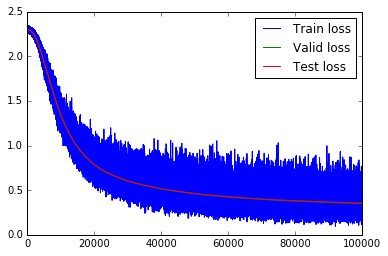

In [6]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

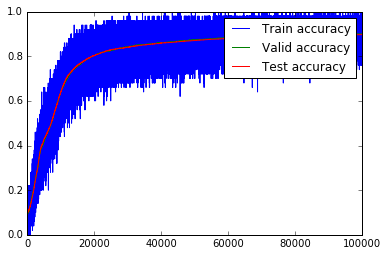

In [7]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()